In [26]:
import statsmodels.stats.diagnostic as diag
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

In [76]:
LAG_ORDER = 2
HORIZON = 20

In [62]:
SIGNIFICANT_P = 0.05
def test_stationarity(data):
    # AIC - autolag parameter which automates
    # the selection of the lag length based on information criteria
    # and penalises complex models.

    # ct - ct: It stands for "constant and trend."
    # The regression model includes both a constant (intercept) and a linear trend term.
    result = adfuller(data, maxlag=LAG_ORDER, regression='ct')
    isStationary = False
    if (result[0] < result[4]["1%"] and result[0] < result[4]["5%"] and result[0] < result[4]["10%"]\
        and result[1] < SIGNIFICANT_P):
        isStationary = True
    else:
        isStationary = False
    
    return { "stationarity": result, "isStationary": isStationary }

In [30]:
def forecast_accuracy(forecast, actual):
        print(forecast)
        print("------------")
        print(actual)
        mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
        me = np.mean(forecast - actual)             # ME
        mae = np.mean(np.abs(forecast - actual))    # MAE
        mpe = np.mean((forecast - actual)/actual)   # MPE
        rmse = np.mean((forecast - actual)**2)**.5  # RMSE
        # corr = np.corrcoef(forecast, actual)[0,1]   # corr
        # mins = np.amin(np.hstack([forecast[:,None], 
        #                         actual[:,None]]), axis=1)
        # maxs = np.amax(np.hstack([forecast[:,None], 
        #                         actual[:,None]]), axis=1)
        # minmax = 1 - np.mean(mins/maxs)             # minmax
        return({'mape':mape, 'me':me, 'mae': mae, 
                'mpe': mpe, 'rmse':rmse })


In [48]:
def convert_data_to_stationary(df):
    # how to deal with non linear non stationarity?
    # put an upper limit on the order
    df_diff = df.copy()
    diff_order = -1
    is_stationary = False
    while is_stationary == False:
        diff_order += 1
        for i in range(len(df_diff.columns)):

            stationarityTestResult = test_stationarity(df_diff[df_diff.columns[i]])
            is_stationary = stationarityTestResult["isStationary"]
            print('Column {0} stationarity: {1}'.format(df_diff.columns[i], is_stationary))
            if is_stationary == False:
                break
        print("is_stationary -> {0}, differenced {1} times".format(is_stationary, diff_order))
        # Apply differencing to make data stationary
        df_diff = df_diff.diff().dropna()
    return df_diff, diff_order

In [68]:
class Predict:
    def __init__(self):
        self = self


    def df_test_transformation(self, df, scaler):
        print("sound (original)")
        plt.hist(df["sound"])
        plt.show()
        
        df_diff, diff_order = convert_data_to_stationary(df)  


        # Scale data using the previously defined scaler
        df_scaled = pd.DataFrame(scaler.fit_transform(df_diff), 
                            columns=df_diff.columns, 
                            index=df_diff.index)
        
        
        print("sound (differenced)")
        plt.hist(df_diff["sound"], bins=np.linspace(-5, 5, 100))
        plt.show()

        print("sound (scaled)")
        plt.hist(df_scaled["sound"], bins=np.linspace(-10, 10, 100))
        plt.show()

        return df_scaled, diff_order
    
    def df_inv_transformation(self, pred, df_original, scaler):
        forecast = pred.copy()
        df_diff = pd.DataFrame(scaler.inverse_transform(forecast), 
                        columns=forecast.columns, 
                        index=forecast.index)
        columns = df_original.columns
        for col in columns:
            df_diff[str(col)] = df_original[col][df_original.index < pred.index[0]].iloc[-1] + \
                df_diff[str(col)+"_pred"].cumsum()
        return df_diff
    
    def test_var(self, df_input):
        df_input.index = pd.to_datetime(df_input.index, unit = 'ms')
        # Is this ts unique? (check with pandas)
        scaler = StandardScaler()

        # # Apply function to our data
        df_scaled, diff_order = self.df_test_transformation(df_input, scaler)
        cutoff_index = int(df_scaled.shape[0] * 0.9)
        df_train = df_scaled.iloc[:cutoff_index]
        df_test = df_scaled.iloc[cutoff_index:]

        model = VAR(df_train)
        # Get optimal lag order based on the four criteria
        optimal_lags = model.select_order()

        print(f"The optimal lag order selected: {optimal_lags.selected_orders}")
        # Fit the model after selecting the lag order
        lag_order = LAG_ORDER # optimal_lags.selected_orders['aic']
        results = model.fit(lag_order)
        print(results)
        print(results.params)
        # print(results.rsquared)
        print(str(results.summary()))
        # Estimate the model (VAR) and show summary
        # Forecast next two weeks
        horizon = HORIZON
        def run_forecast(df_to_run_forecast_on, df_original):
            forecast = results.forecast(df_to_run_forecast_on.values[-lag_order:], steps=horizon)

            idx = pd.date_range(pd.to_datetime(df_to_run_forecast_on.iloc[-1:].index.item(), unit='ms'), periods=horizon, freq='120s')
            # Convert to dataframe
            df_forecast = pd.DataFrame(forecast, 
                            columns=df_to_run_forecast_on.columns + '_pred', 
                            index=idx)
            
            # # Invert the transformations to bring it back to the original scale
            # df_forecast_original = self.df_inv_transformation(df_forecast, df_original, scaler)

            return df_forecast
        
        df_forecast_on_train_data = run_forecast(df_train, df_input)
        # Invert the transformations to bring it back to the original scale
        df_forecast_on_train_data_original = self.df_inv_transformation(df_forecast_on_train_data, df_input, scaler)

        df_forecast_test_data = run_forecast(df_test, df_input)
        df_forecast_on_test_data_original = self.df_inv_transformation(df_forecast_test_data, df_input, scaler)
    
        df_forecast_future_data = run_forecast(df_scaled, df_input)
        print(df_forecast_test_data)
        predicted_values = df_forecast_test_data["sound_pred"]
        actual_values_df = df_scaled[df_scaled.index.isin(predicted_values.index)] 
        actual_values = actual_values_df["sound"]

        evaluation_result = forecast_accuracy(predicted_values, actual_values)

        print("Evaluate test data: ")
        print(evaluation_result)
        # print(evaluation_result)
        
        # json_result = df_forecast_on_test_data_original.to_json()
        # with open('data.json', 'w', encoding='utf-8') as f:
        #     json.dump(json_result, f, ensure_ascii=False, indent=4)
        # return json_result

In [69]:
f = open('/Users/yarynakorduba/Projects/master-thesis-full-stack/src/front/js/pages/App/test.json')
data_serie = json.load(f)
data_serie[1]

{'oxygen': 20.636,
 'timestamp': 1690675362000,
 'health': 809,
 'dewpt': 15.702,
 'no2': 48.89,
 'TypPS': 1.7,
 'tvoc': 383,
 'gauss': 0.8380579546869671,
 'sound': 32.06,
 'temperature': 23.611,
 'co2': 413}

In [70]:
data_serie_trimmed = data_serie
data_df = pd.DataFrame.from_records(data_serie_trimmed)
data_df = data_df.filter(['sound','co2'], axis=1)

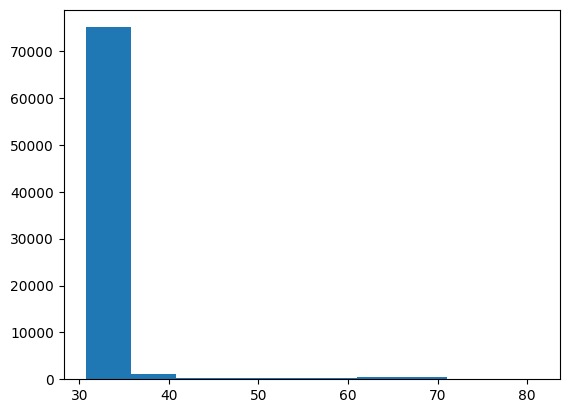

In [34]:
plt.hist(data_df["sound"])
plt.show()

In [45]:
data_df.isna().sum() # -> no missing values imputation needed

sound    0
co2      0
dtype: int64

In [46]:
data_df.min()


sound     30.77
co2      405.10
dtype: float64

In [47]:
data_df.max()

sound      81.09
co2      1666.80
dtype: float64

In [63]:
df_diff, diff_order = convert_data_to_stationary(data_df)  

Column sound stationarity: True
Column co2 stationarity: True
is_stationary -> True, differenced 0 times


sound (original)


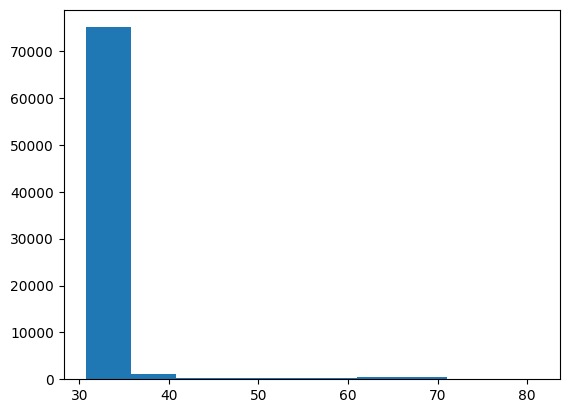

Column sound stationarity: True
Column co2 stationarity: True
is_stationary -> True, differenced 0 times
sound (differenced)


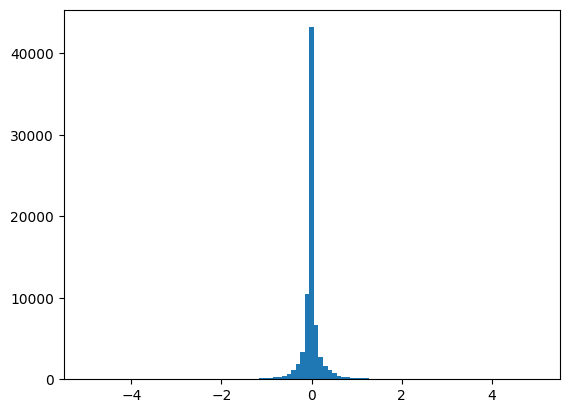

sound (scaled)


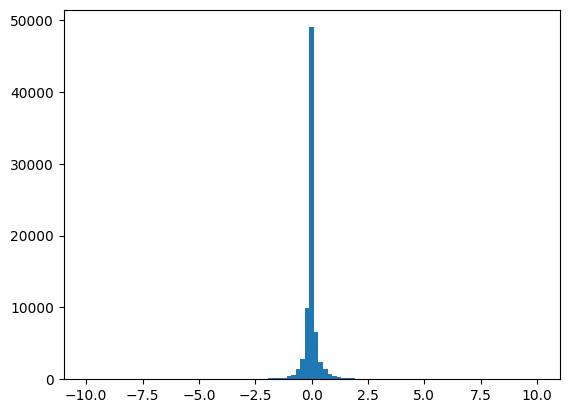

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


The optimal lag order selected: {'aic': 62, 'bic': 62, 'hqic': 62, 'fpe': 62}
              sound       co2
const     -0.000032  0.000246
L1.sound  -0.148059  0.061686
L1.co2    -0.035996 -0.091187
L2.sound  -0.116644  0.053934
L2.co2    -0.019480 -0.035737
...             ...       ...
L60.co2    0.029932 -0.029622
L61.sound -0.009726  0.025012
L61.co2    0.014269  0.046349
L62.sound -0.003486  0.017972
L62.co2    0.012509 -0.015083

[125 rows x 2 columns]
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 25, Feb, 2024
Time:                     13:23:58
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                 -0.0802476
Nobs:                     70498.0    HQIC:                 -0.102724
Log likelihood:          -195841.    FPE:                   0.893381
AIC:                    -0.112743    Det(Omega_mle):        0.890221
------------------

In [71]:
result = Predict().test_var(data_df)

In [72]:
# Generate sinusoidal data
np.random.seed(42)
t = np.linspace(0, 2*np.pi, 100)
sin_data = np.sin(t) + np.random.normal(scale=0.1, size=len(t))


In [74]:
data = pd.DataFrame({'sin_data': sin_data})


In [75]:
data

sin_data
0   0.049671
1   0.049597
2   0.191361
3   0.341554
4   0.227733
..       ...
95 -0.397499
96 -0.159639
97 -0.100487
98 -0.062913
99 -0.023459

[100 rows x 1 columns]

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error

In [281]:
lagged_data_order = 2  # You can adjust the number of lags based on the characteristics of your data
key = 'sin_data'
steps = 20
# Generate sinusoidal data
np.random.seed(42)
t = np.linspace(0, 4*np.pi, 1000)
sin_data = np.sin(t) + np.random.normal(scale=0.1, size=len(t))

# Create a DataFrame
data = pd.DataFrame(sin_data, columns=[key])


# Lag the data to create a VAR model
for i in range(1, lagged_data_order):
    data[f'{key}_lag{i}'] = data[key].shift(i)

# Drop NaN values created by lagging
data = data.dropna()


In [283]:
lagged_data_order = 2  # You can adjust the number of lags based on the characteristics of your data
steps = 100
key = 'sound'
data = data_df.copy()
# data = data.filter([key], axis=1)
# Lag the data to create a VAR model
# for i in range(1, lagged_data_order):
#     data[f'{key}_lag{i}'] = data[key].shift(i)
data = data.dropna()
data[key] = data[key].astype(float)
np.asarray(data)
data

sound    co2
1970-01-01 00:00:00.000  32.08  413.0
1970-01-01 00:00:00.001  32.06  413.0
1970-01-01 00:00:00.002  32.07  411.9
1970-01-01 00:00:00.003  32.10  411.7
1970-01-01 00:00:00.004  32.07  411.6
...                        ...    ...
1970-01-01 00:01:18.396  33.29  459.2
1970-01-01 00:01:18.397  33.35  459.0
1970-01-01 00:01:18.398  33.37  458.8
1970-01-01 00:01:18.399  33.34  458.7
1970-01-01 00:01:18.400  33.20  459.0

[78401 rows x 2 columns]

Train size 62720
                             sound         co2
1970-01-01 00:01:02.720  32.875849  503.174667
1970-01-01 00:01:02.721  32.928660  503.055483
1970-01-01 00:01:02.722  32.978596  502.942114
1970-01-01 00:01:02.723  33.025815  502.834246
1970-01-01 00:01:02.724  33.070464  502.731581
...                            ...         ...
1970-01-01 00:01:02.815  33.831934  500.117886
1970-01-01 00:01:02.816  33.832040  500.106538
1970-01-01 00:01:02.817  33.832133  500.095233
1970-01-01 00:01:02.818  33.832212  500.083970
1970-01-01 00:01:02.819  33.832279  500.072747

[100 rows x 2 columns]
                         sound    co2
1970-01-01 00:01:02.720  32.83  503.5
1970-01-01 00:01:02.721  33.12  504.8
1970-01-01 00:01:02.722  32.83  504.4
1970-01-01 00:01:02.723  32.79  504.2
1970-01-01 00:01:02.724  32.82  504.3
...                        ...    ...
1970-01-01 00:01:02.815  32.70  501.4
1970-01-01 00:01:02.816  32.75  501.4
1970-01-01 00:01:02.817  32.75  501.3
1970-01-01 00:0

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.866621  503.188435
1970-01-01 00:01:02.721  32.904823  503.123745
1970-01-01 00:01:02.722  32.941671  503.051622
1970-01-01 00:01:02.723  32.977261  502.983536
1970-01-01 00:01:02.724  33.011397  502.917623
...                            ...         ...
1970-01-01 00:01:02.815  33.823087  500.798025
1970-01-01 00:01:02.816  33.823857  500.788734
1970-01-01 00:01:02.817  33.824594  500.779509
1970-01-01 00:01:02.818  33.825297  500.770346
1970-01-01 00:01:02.819  33.825969  500.761243

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

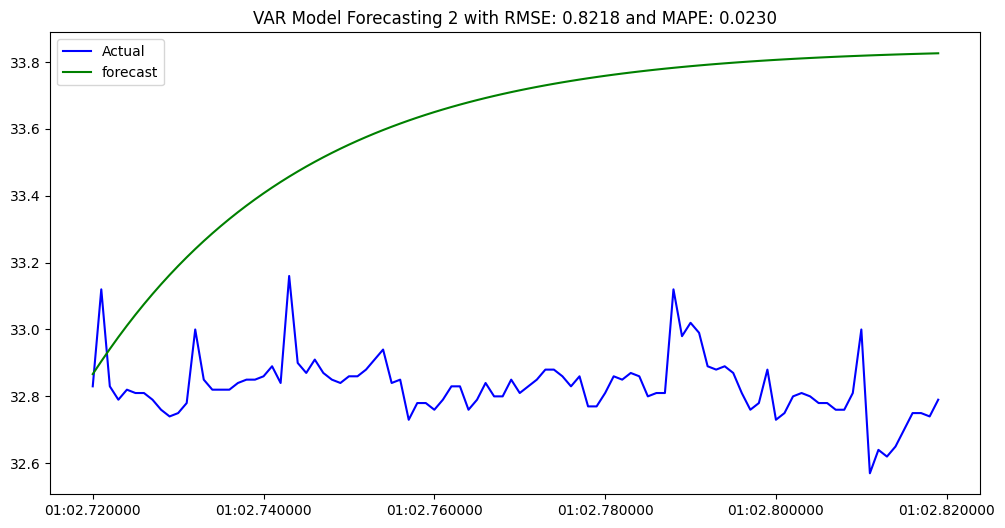

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.860369  503.188286
1970-01-01 00:01:02.721  32.891921  503.122885
1970-01-01 00:01:02.722  32.917305  503.072275
1970-01-01 00:01:02.723  32.943317  503.011071
1970-01-01 00:01:02.724  32.969151  502.951459
...                            ...         ...
1970-01-01 00:01:02.815  33.775381  500.753263
1970-01-01 00:01:02.816  33.777102  500.743665
1970-01-01 00:01:02.817  33.778772  500.734175
1970-01-01 00:01:02.818  33.780392  500.724790
1970-01-01 00:01:02.819  33.781964  500.715507

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

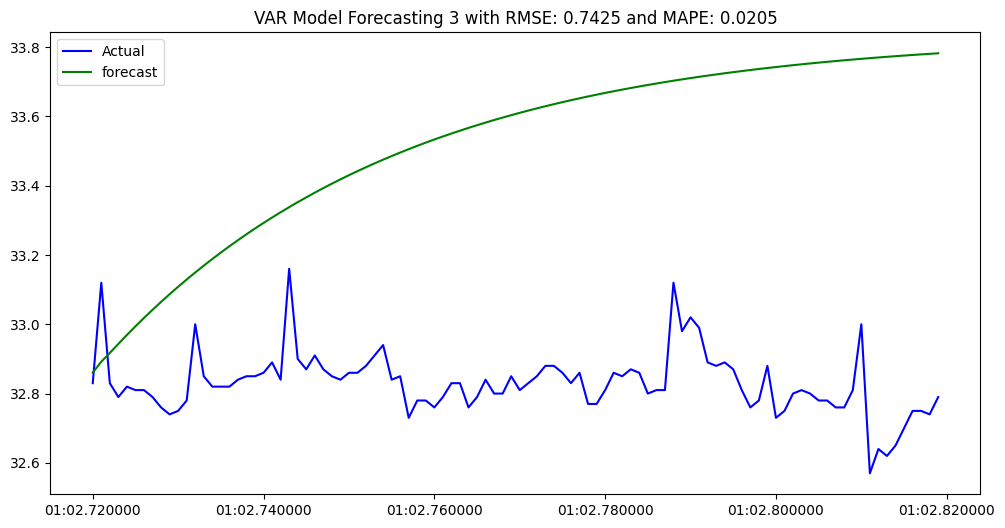

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.856880  503.189613
1970-01-01 00:01:02.721  32.889591  503.128465
1970-01-01 00:01:02.722  32.915114  503.083359
1970-01-01 00:01:02.723  32.935661  503.023158
1970-01-01 00:01:02.724  32.959239  502.964620
...                            ...         ...
1970-01-01 00:01:02.815  33.743855  500.622070
1970-01-01 00:01:02.816  33.745783  500.610323
1970-01-01 00:01:02.817  33.747658  500.598692
1970-01-01 00:01:02.818  33.749481  500.587174
1970-01-01 00:01:02.819  33.751254  500.575766

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

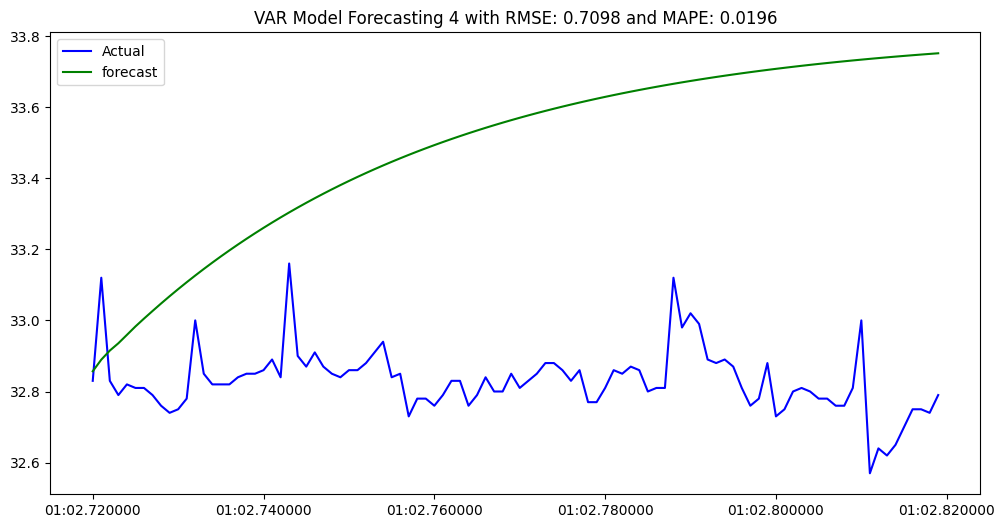

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.856068  503.186406
1970-01-01 00:01:02.721  32.888598  503.122425
1970-01-01 00:01:02.722  32.912307  503.079933
1970-01-01 00:01:02.723  32.931019  503.019917
1970-01-01 00:01:02.724  32.954609  502.954756
...                            ...         ...
1970-01-01 00:01:02.815  33.739043  500.464504
1970-01-01 00:01:02.816  33.741146  500.452038
1970-01-01 00:01:02.817  33.743195  500.439703
1970-01-01 00:01:02.818  33.745189  500.427495
1970-01-01 00:01:02.819  33.747132  500.415411

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

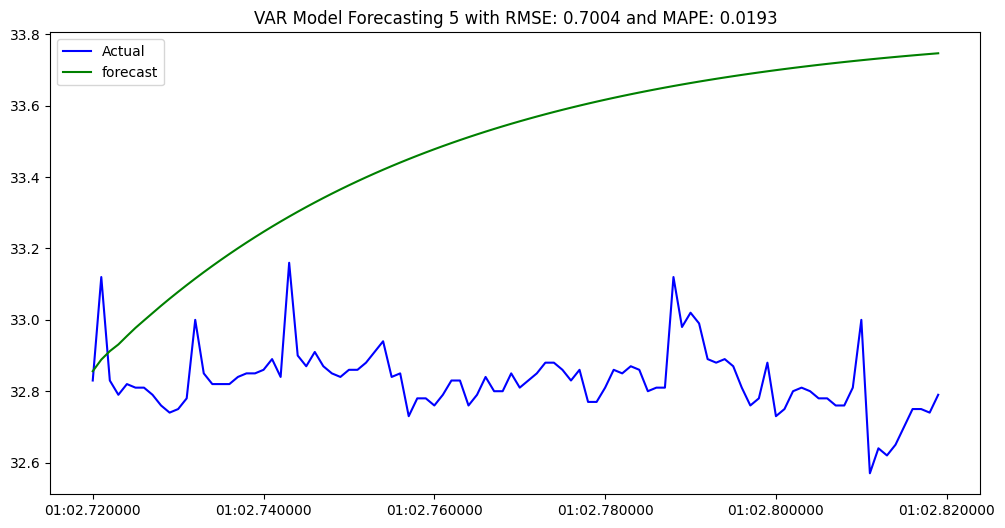

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.854508  503.179563
1970-01-01 00:01:02.721  32.884871  503.111719
1970-01-01 00:01:02.722  32.907408  503.066254
1970-01-01 00:01:02.723  32.925809  502.999227
1970-01-01 00:01:02.724  32.948757  502.927525
...                            ...         ...
1970-01-01 00:01:02.815  33.715465  500.160517
1970-01-01 00:01:02.816  33.717761  500.147067
1970-01-01 00:01:02.817  33.720000  500.133776
1970-01-01 00:01:02.818  33.722186  500.120639
1970-01-01 00:01:02.819  33.724318  500.107653

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

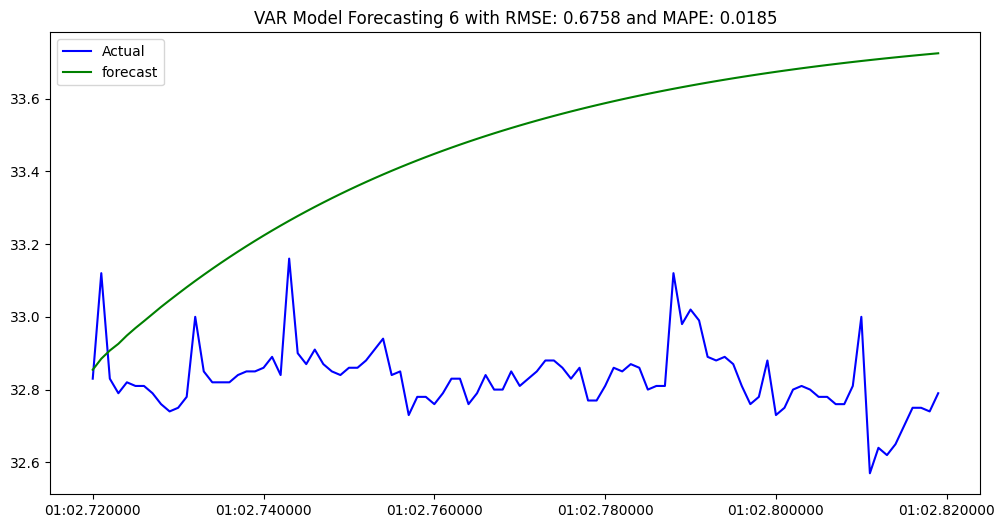

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.850944  503.201617
1970-01-01 00:01:02.721  32.878792  503.134705
1970-01-01 00:01:02.722  32.897274  503.079661
1970-01-01 00:01:02.723  32.914139  503.007709
1970-01-01 00:01:02.724  32.936574  502.944267
...                            ...         ...
1970-01-01 00:01:02.815  33.665020  499.690243
1970-01-01 00:01:02.816  33.667673  499.672456
1970-01-01 00:01:02.817  33.670271  499.654862
1970-01-01 00:01:02.818  33.672813  499.637459
1970-01-01 00:01:02.819  33.675303  499.620241

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

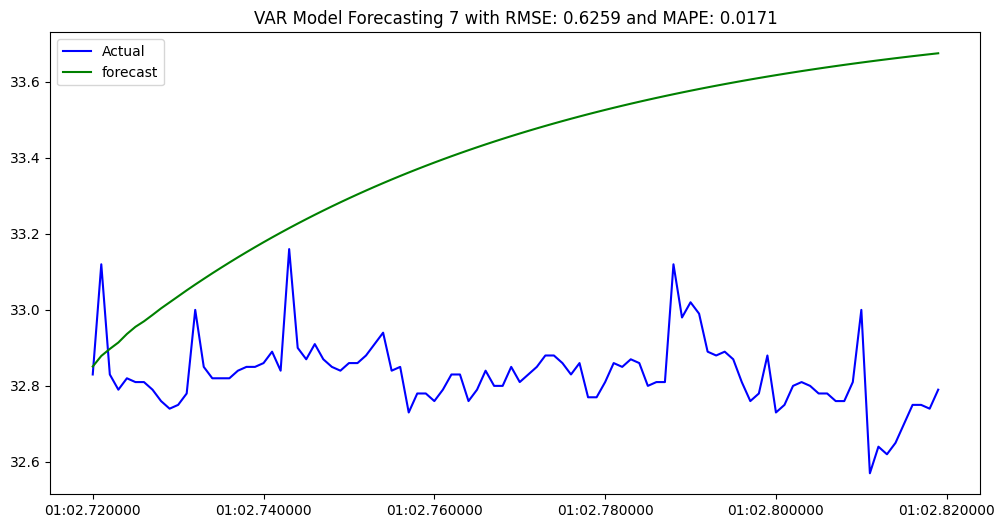

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.853941  503.237372
1970-01-01 00:01:02.721  32.882912  503.191260
1970-01-01 00:01:02.722  32.900597  503.136249
1970-01-01 00:01:02.723  32.917203  503.053960
1970-01-01 00:01:02.724  32.938797  502.985313
...                            ...         ...
1970-01-01 00:01:02.815  33.649975  499.231613
1970-01-01 00:01:02.816  33.652566  499.209284
1970-01-01 00:01:02.817  33.655102  499.187177
1970-01-01 00:01:02.818  33.657586  499.165286
1970-01-01 00:01:02.819  33.660017  499.143609

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

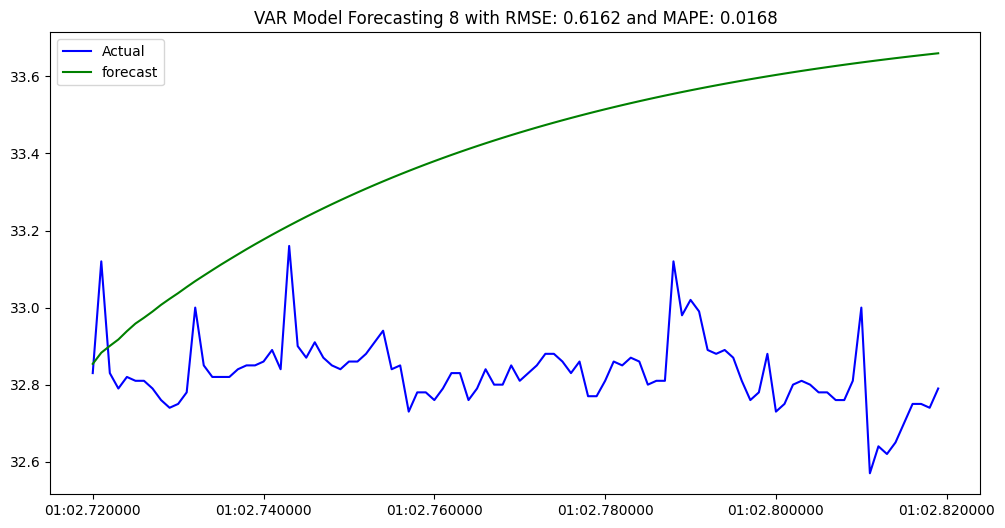

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.854563  503.269727
1970-01-01 00:01:02.721  32.884606  503.240944
1970-01-01 00:01:02.722  32.905065  503.205296
1970-01-01 00:01:02.723  32.923631  503.131701
1970-01-01 00:01:02.724  32.946533  503.068539
...                            ...         ...
1970-01-01 00:01:02.815  33.681904  499.757428
1970-01-01 00:01:02.816  33.684220  499.735100
1970-01-01 00:01:02.817  33.686482  499.712942
1970-01-01 00:01:02.818  33.688690  499.690949
1970-01-01 00:01:02.819  33.690846  499.669120

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

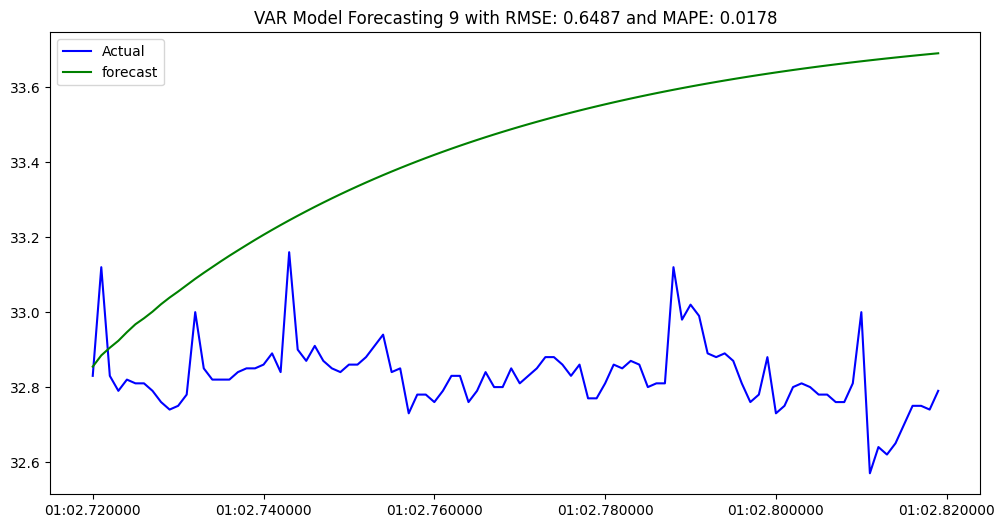

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.852784  503.281980
1970-01-01 00:01:02.721  32.877511  503.261906
1970-01-01 00:01:02.722  32.895199  503.231701
1970-01-01 00:01:02.723  32.911225  503.170840
1970-01-01 00:01:02.724  32.933654  503.111766
...                            ...         ...
1970-01-01 00:01:02.815  33.678832  500.198064
1970-01-01 00:01:02.816  33.681400  500.176097
1970-01-01 00:01:02.817  33.683910  500.154263
1970-01-01 00:01:02.818  33.686364  500.132561
1970-01-01 00:01:02.819  33.688764  500.110987

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

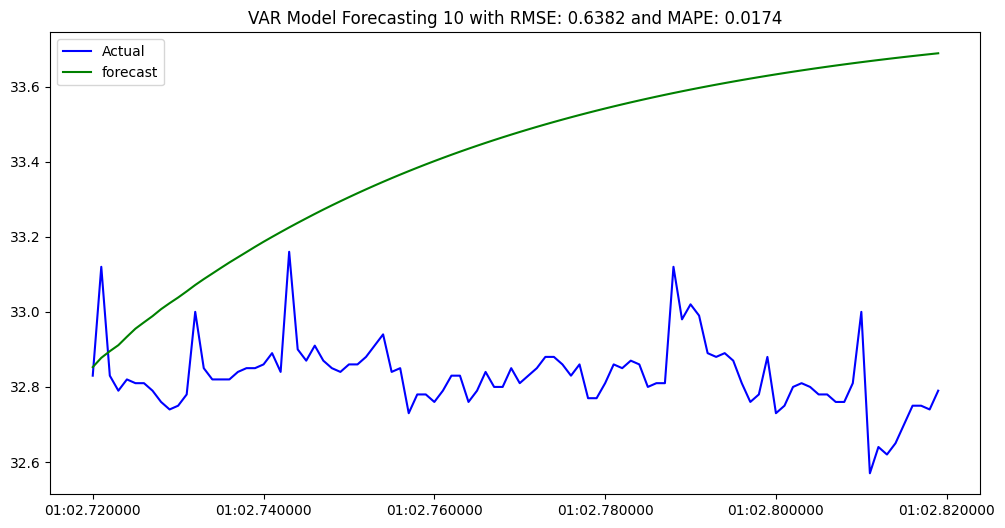

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.856541  503.304962
1970-01-01 00:01:02.721  32.879350  503.275689
1970-01-01 00:01:02.722  32.895296  503.237341
1970-01-01 00:01:02.723  32.911382  503.173010
1970-01-01 00:01:02.724  32.931762  503.106375
...                            ...         ...
1970-01-01 00:01:02.815  33.670642  499.919559
1970-01-01 00:01:02.816  33.673286  499.897255
1970-01-01 00:01:02.817  33.675873  499.875115
1970-01-01 00:01:02.818  33.678405  499.853138
1970-01-01 00:01:02.819  33.680882  499.831321

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

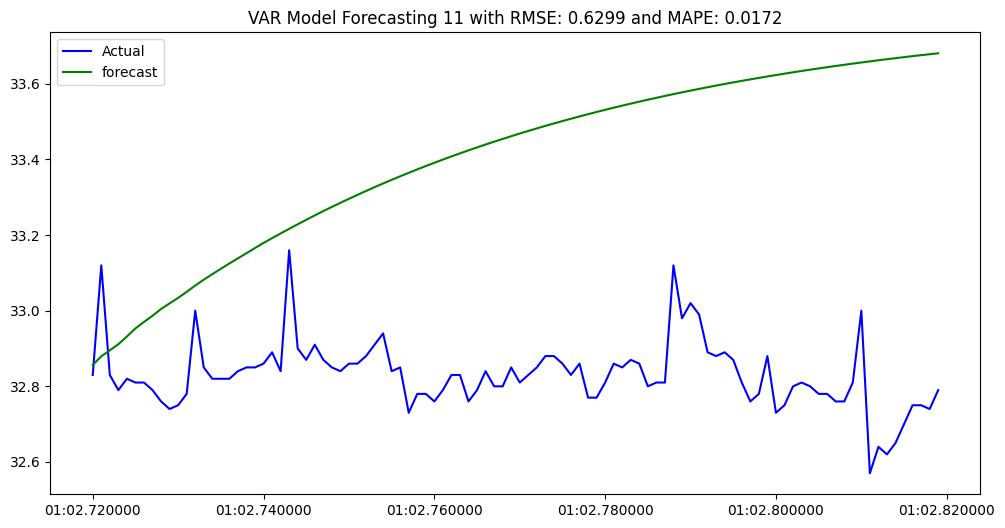

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.858335  503.259902
1970-01-01 00:01:02.721  32.871255  503.231381
1970-01-01 00:01:02.722  32.891968  503.191434
1970-01-01 00:01:02.723  32.909359  503.148661
1970-01-01 00:01:02.724  32.932454  503.090344
...                            ...         ...
1970-01-01 00:01:02.815  33.689509  499.817761
1970-01-01 00:01:02.816  33.691887  499.793676
1970-01-01 00:01:02.817  33.694208  499.769752
1970-01-01 00:01:02.818  33.696473  499.745986
1970-01-01 00:01:02.819  33.698684  499.722376

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

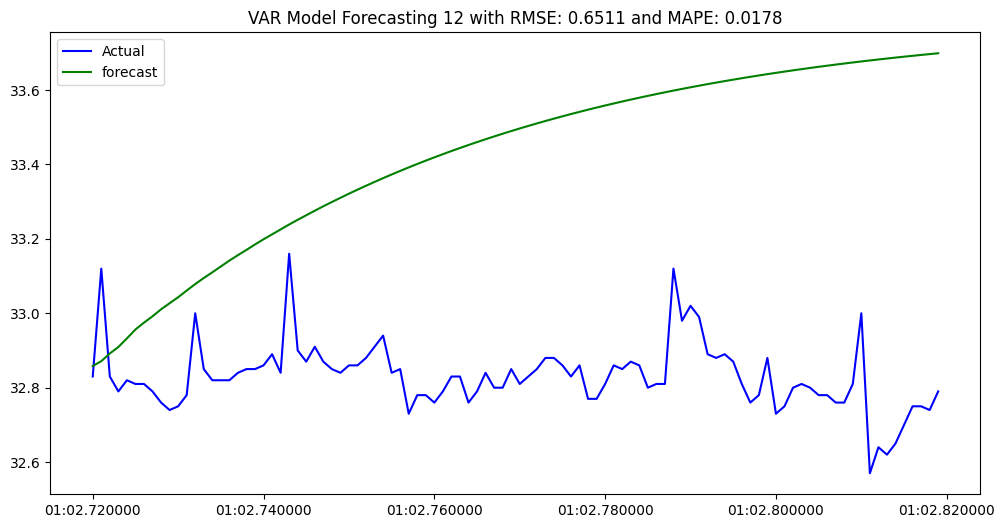

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.857652  503.261568
1970-01-01 00:01:02.721  32.865787  503.236498
1970-01-01 00:01:02.722  32.893089  503.199988
1970-01-01 00:01:02.723  32.907881  503.155894
1970-01-01 00:01:02.724  32.931592  503.094196
...                            ...         ...
1970-01-01 00:01:02.815  33.670207  499.663115
1970-01-01 00:01:02.816  33.672725  499.638428
1970-01-01 00:01:02.817  33.675188  499.613922
1970-01-01 00:01:02.818  33.677596  499.589594
1970-01-01 00:01:02.819  33.679949  499.565441

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

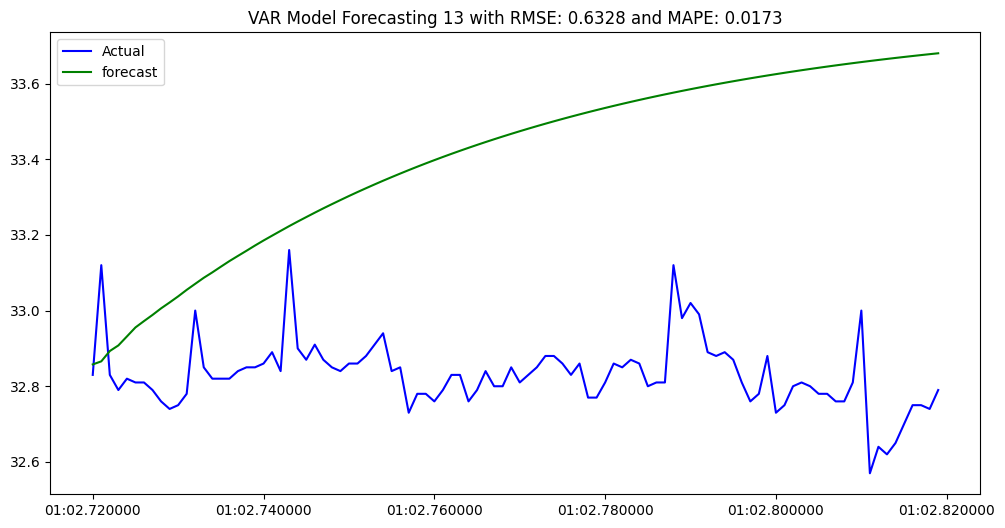

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.860557  503.261896
1970-01-01 00:01:02.721  32.864365  503.230660
1970-01-01 00:01:02.722  32.878957  503.160118
1970-01-01 00:01:02.723  32.892692  503.129583
1970-01-01 00:01:02.724  32.918270  503.055629
...                            ...         ...
1970-01-01 00:01:02.815  33.647303  499.163002
1970-01-01 00:01:02.816  33.649705  499.134702
1970-01-01 00:01:02.817  33.652055  499.106626
1970-01-01 00:01:02.818  33.654353  499.078772
1970-01-01 00:01:02.819  33.656600  499.051135

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.859942  503.246405
1970-01-01 00:01:02.721  32.864578  503.231803
1970-01-01 00:01:02.722  32.878685  503.151344
1970-01-01 00:01:02.723  32.891129  503.100247
1970-01-01 00:01:02.724  32.916729  502.994305
...                            ...         ...
1970-01-01 00:01:02.815  33.651977  499.397813
1970-01-01 00:01:02.816  33.654309  499.368511
1970-01-01 00:01:02.817  33.656588  499.339392
1970-01-01 00:01:02.818  33.658816  499.310455
1970-01-01 00:01:02.819  33.660993  499.281697

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.859899  503.248929
1970-01-01 00:01:02.721  32.864514  503.227951
1970-01-01 00:01:02.722  32.878752  503.141499
1970-01-01 00:01:02.723  32.891355  503.090041
1970-01-01 00:01:02.724  32.916760  502.961497
...                            ...         ...
1970-01-01 00:01:02.815  33.642746  498.793526
1970-01-01 00:01:02.816  33.645063  498.761789
1970-01-01 00:01:02.817  33.647329  498.730314
1970-01-01 00:01:02.818  33.649545  498.699095
1970-01-01 00:01:02.819  33.651712  498.668129

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.858418  503.256232
1970-01-01 00:01:02.721  32.864307  503.228420
1970-01-01 00:01:02.722  32.878109  503.145426
1970-01-01 00:01:02.723  32.889041  503.103597
1970-01-01 00:01:02.724  32.914201  502.972949
...                            ...         ...
1970-01-01 00:01:02.815  33.630932  499.292250
1970-01-01 00:01:02.816  33.633434  499.261952
1970-01-01 00:01:02.817  33.635884  499.231845
1970-01-01 00:01:02.818  33.638283  499.201931
1970-01-01 00:01:02.819  33.640632  499.172208

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.854277  503.273274
1970-01-01 00:01:02.721  32.859120  503.240305
1970-01-01 00:01:02.722  32.875728  503.143375
1970-01-01 00:01:02.723  32.887885  503.088548
1970-01-01 00:01:02.724  32.909523  502.972961
...                            ...         ...
1970-01-01 00:01:02.815  33.603716  499.025080
1970-01-01 00:01:02.816  33.606394  498.991519
1970-01-01 00:01:02.817  33.609022  498.958171
1970-01-01 00:01:02.818  33.611599  498.925033
1970-01-01 00:01:02.819  33.614128  498.892105

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.851817  503.277825
1970-01-01 00:01:02.721  32.855141  503.246570
1970-01-01 00:01:02.722  32.871031  503.144943
1970-01-01 00:01:02.723  32.884676  503.086603
1970-01-01 00:01:02.724  32.905361  502.964086
...                            ...         ...
1970-01-01 00:01:02.815  33.574650  498.627345
1970-01-01 00:01:02.816  33.577425  498.590525
1970-01-01 00:01:02.817  33.580151  498.553968
1970-01-01 00:01:02.818  33.582830  498.517668
1970-01-01 00:01:02.819  33.585462  498.481625

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.850192  503.288478
1970-01-01 00:01:02.721  32.854419  503.253387
1970-01-01 00:01:02.722  32.870923  503.150211
1970-01-01 00:01:02.723  32.883882  503.099408
1970-01-01 00:01:02.724  32.903460  502.978691
...                            ...         ...
1970-01-01 00:01:02.815  33.564165  499.182381
1970-01-01 00:01:02.816  33.567013  499.149117
1970-01-01 00:01:02.817  33.569812  499.116051
1970-01-01 00:01:02.818  33.572564  499.083169
1970-01-01 00:01:02.819  33.575270  499.050475

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

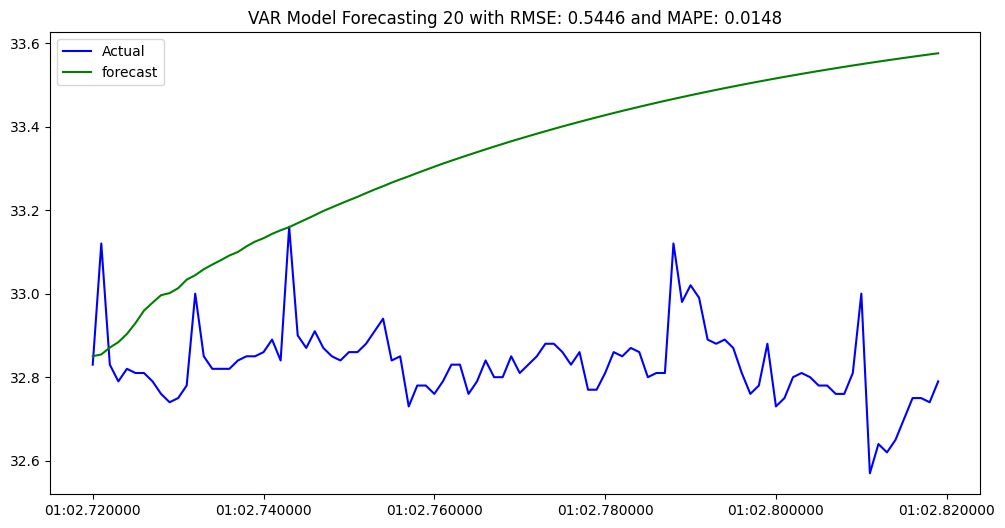

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.853326  503.282711
1970-01-01 00:01:02.721  32.856747  503.268845
1970-01-01 00:01:02.722  32.880884  503.161364
1970-01-01 00:01:02.723  32.898416  503.110764
1970-01-01 00:01:02.724  32.915956  503.006250
...                            ...         ...
1970-01-01 00:01:02.815  33.568104  500.216834
1970-01-01 00:01:02.816  33.570882  500.189987
1970-01-01 00:01:02.817  33.573606  500.163203
1970-01-01 00:01:02.818  33.576283  500.136476
1970-01-01 00:01:02.819  33.578915  500.109814

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

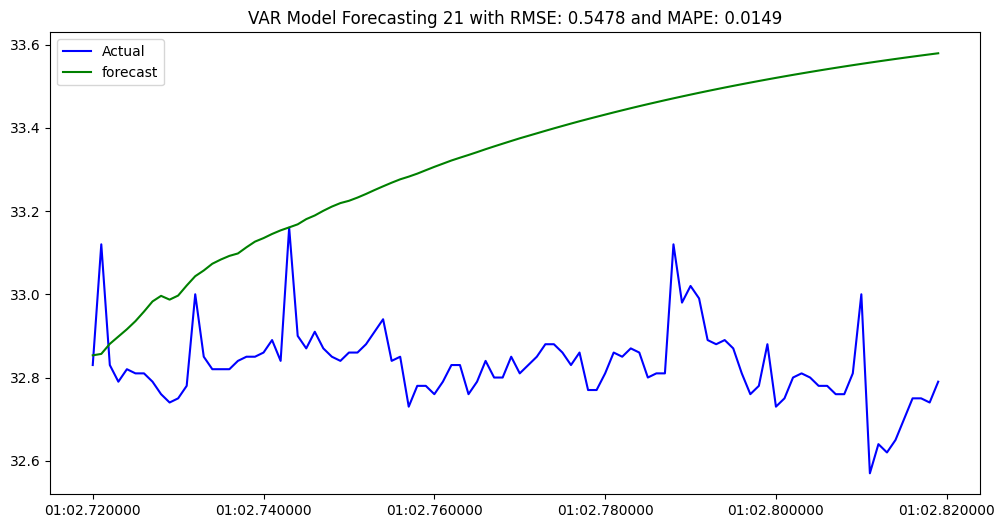

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.852178  503.266671
1970-01-01 00:01:02.721  32.855989  503.247081
1970-01-01 00:01:02.722  32.881223  503.143687
1970-01-01 00:01:02.723  32.898593  503.069852
1970-01-01 00:01:02.724  32.916837  502.951092
...                            ...         ...
1970-01-01 00:01:02.815  33.578167  500.372868
1970-01-01 00:01:02.816  33.580970  500.348713
1970-01-01 00:01:02.817  33.583719  500.324644
1970-01-01 00:01:02.818  33.586415  500.300659
1970-01-01 00:01:02.819  33.589059  500.276714

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.843846  503.231934
1970-01-01 00:01:02.721  32.851052  503.204591
1970-01-01 00:01:02.722  32.875958  503.096166
1970-01-01 00:01:02.723  32.889977  503.020488
1970-01-01 00:01:02.724  32.904154  502.871143
...                            ...         ...
1970-01-01 00:01:02.815  33.553832  500.112726
1970-01-01 00:01:02.816  33.556837  500.089366
1970-01-01 00:01:02.817  33.559790  500.066084
1970-01-01 00:01:02.818  33.562700  500.042942
1970-01-01 00:01:02.819  33.565559  500.019911

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

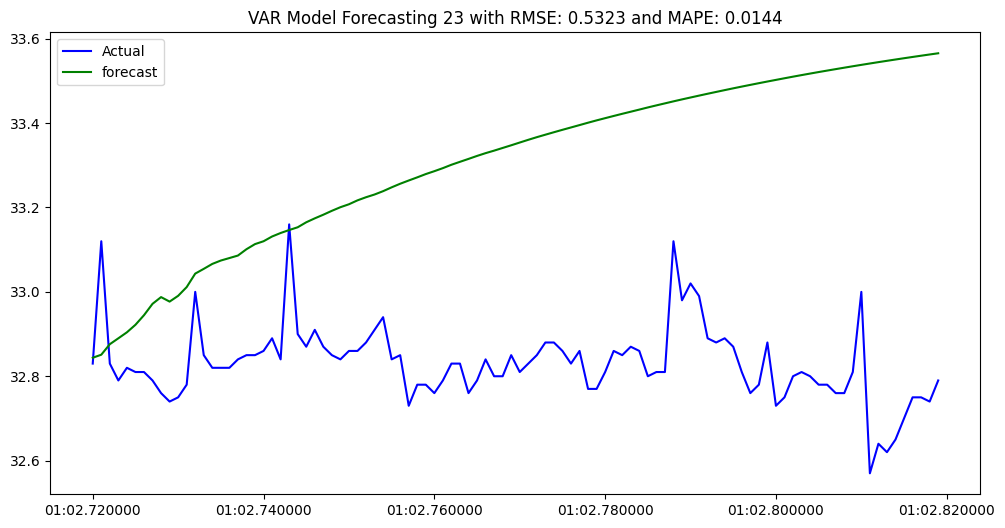

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.843871  503.234898
1970-01-01 00:01:02.721  32.856168  503.196613
1970-01-01 00:01:02.722  32.879900  503.083128
1970-01-01 00:01:02.723  32.894503  503.007741
1970-01-01 00:01:02.724  32.909225  502.861382
...                            ...         ...
1970-01-01 00:01:02.815  33.566664  500.287647
1970-01-01 00:01:02.816  33.569597  500.265928
1970-01-01 00:01:02.817  33.572476  500.244240
1970-01-01 00:01:02.818  33.575316  500.222623
1970-01-01 00:01:02.819  33.578110  500.201092

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

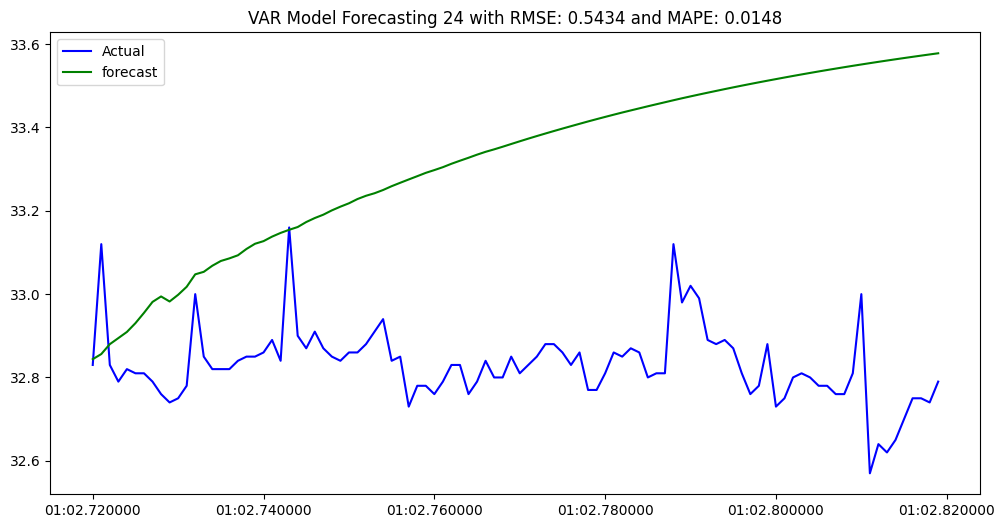

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.848471  503.252738
1970-01-01 00:01:02.721  32.861178  503.218222
1970-01-01 00:01:02.722  32.889978  503.129947
1970-01-01 00:01:02.723  32.897964  503.031388
1970-01-01 00:01:02.724  32.912692  502.887509
...                            ...         ...
1970-01-01 00:01:02.815  33.619632  501.247552
1970-01-01 00:01:02.816  33.622418  501.230583
1970-01-01 00:01:02.817  33.625134  501.213525
1970-01-01 00:01:02.818  33.627808  501.196456
1970-01-01 00:01:02.819  33.630443  501.179422

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.846997  503.254100
1970-01-01 00:01:02.721  32.856878  503.221801
1970-01-01 00:01:02.722  32.885024  503.131401
1970-01-01 00:01:02.723  32.897871  503.047129
1970-01-01 00:01:02.724  32.916877  502.899751
...                            ...         ...
1970-01-01 00:01:02.815  33.609911  501.401752
1970-01-01 00:01:02.816  33.612601  501.384677
1970-01-01 00:01:02.817  33.615272  501.367585
1970-01-01 00:01:02.818  33.617913  501.350506
1970-01-01 00:01:02.819  33.620524  501.333413

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.848849  503.248667
1970-01-01 00:01:02.721  32.857806  503.220631
1970-01-01 00:01:02.722  32.884637  503.134847
1970-01-01 00:01:02.723  32.896858  503.050323
1970-01-01 00:01:02.724  32.919955  502.892111
...                            ...         ...
1970-01-01 00:01:02.815  33.609341  501.442474
1970-01-01 00:01:02.816  33.611983  501.426063
1970-01-01 00:01:02.817  33.614600  501.409628
1970-01-01 00:01:02.818  33.617181  501.393150
1970-01-01 00:01:02.819  33.619727  501.376598

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)
/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


                             sound         co2
1970-01-01 00:01:02.720  32.852660  503.237486
1970-01-01 00:01:02.721  32.862867  503.208539
1970-01-01 00:01:02.722  32.888504  503.139838
1970-01-01 00:01:02.723  32.899344  503.079936
1970-01-01 00:01:02.724  32.921981  502.922631
...                            ...         ...
1970-01-01 00:01:02.815  33.638841  502.414202
1970-01-01 00:01:02.816  33.641461  502.403426
1970-01-01 00:01:02.817  33.643989  502.392411
1970-01-01 00:01:02.818  33.646446  502.381077
1970-01-01 00:01:02.819  33.648887  502.369710

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

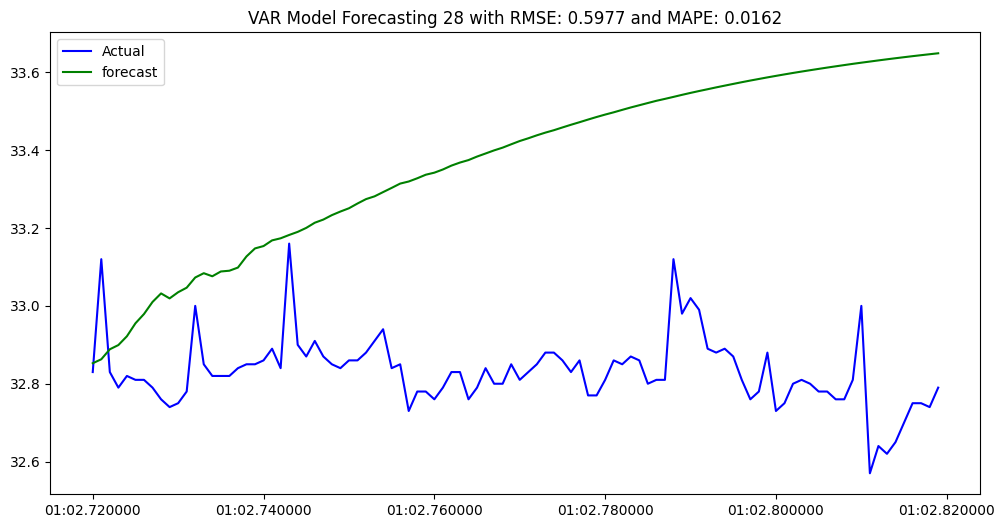

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.856198  503.235225
1970-01-01 00:01:02.721  32.869977  503.205124
1970-01-01 00:01:02.722  32.896416  503.138624
1970-01-01 00:01:02.723  32.905281  503.082132
1970-01-01 00:01:02.724  32.926207  502.926198
...                            ...         ...
1970-01-01 00:01:02.815  33.641786  502.475698
1970-01-01 00:01:02.816  33.644329  502.465099
1970-01-01 00:01:02.817  33.646811  502.454362
1970-01-01 00:01:02.818  33.649156  502.443343
1970-01-01 00:01:02.819  33.651479  502.432161

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.857133  503.226563
1970-01-01 00:01:02.721  32.871565  503.192909
1970-01-01 00:01:02.722  32.898721  503.127790
1970-01-01 00:01:02.723  32.907420  503.071046
1970-01-01 00:01:02.724  32.928000  502.908857
...                            ...         ...
1970-01-01 00:01:02.815  33.625973  501.920233
1970-01-01 00:01:02.816  33.628499  501.906809
1970-01-01 00:01:02.817  33.630949  501.893277
1970-01-01 00:01:02.818  33.633263  501.879331
1970-01-01 00:01:02.819  33.635566  501.865364

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


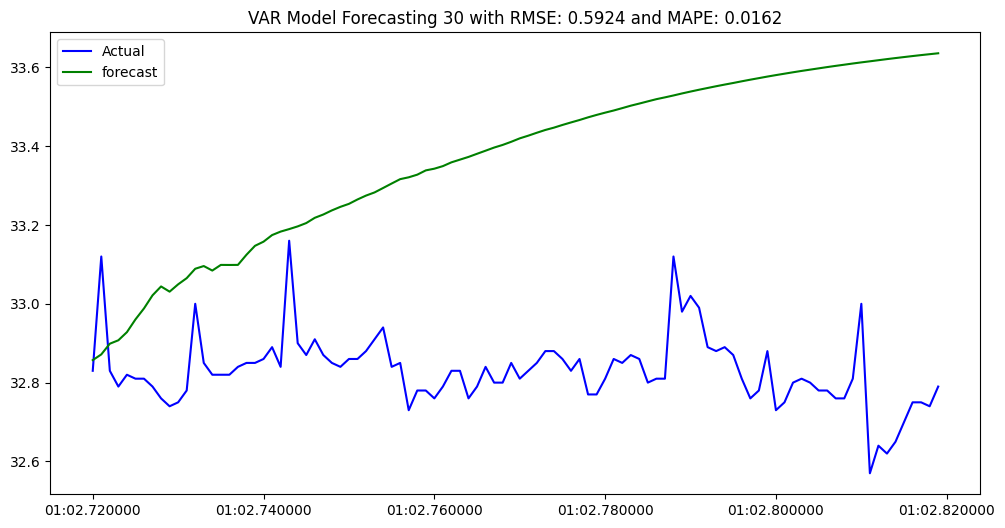

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.852426  503.227739
1970-01-01 00:01:02.721  32.862184  503.198006
1970-01-01 00:01:02.722  32.886550  503.131549
1970-01-01 00:01:02.723  32.892193  503.069028
1970-01-01 00:01:02.724  32.912271  502.904538
...                            ...         ...
1970-01-01 00:01:02.815  33.624392  502.360284
1970-01-01 00:01:02.816  33.627063  502.349782
1970-01-01 00:01:02.817  33.629751  502.339305
1970-01-01 00:01:02.818  33.632292  502.328213
1970-01-01 00:01:02.819  33.634703  502.317056

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


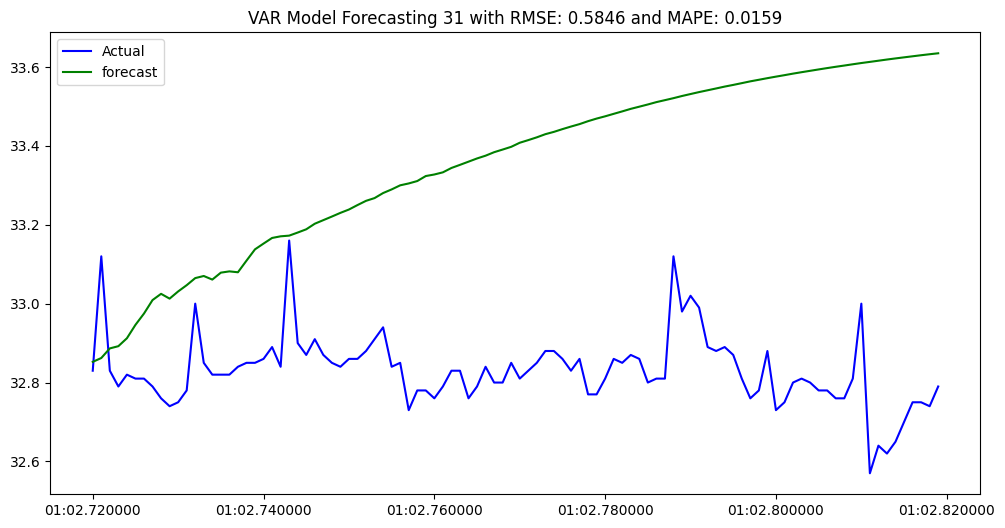

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.851402  503.225201
1970-01-01 00:01:02.721  32.859053  503.189487
1970-01-01 00:01:02.722  32.881032  503.115262
1970-01-01 00:01:02.723  32.885216  503.046679
1970-01-01 00:01:02.724  32.903855  502.876220
...                            ...         ...
1970-01-01 00:01:02.815  33.603429  502.045381
1970-01-01 00:01:02.816  33.606202  502.033628
1970-01-01 00:01:02.817  33.608957  502.021832
1970-01-01 00:01:02.818  33.611647  502.009900
1970-01-01 00:01:02.819  33.614195  501.997864

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


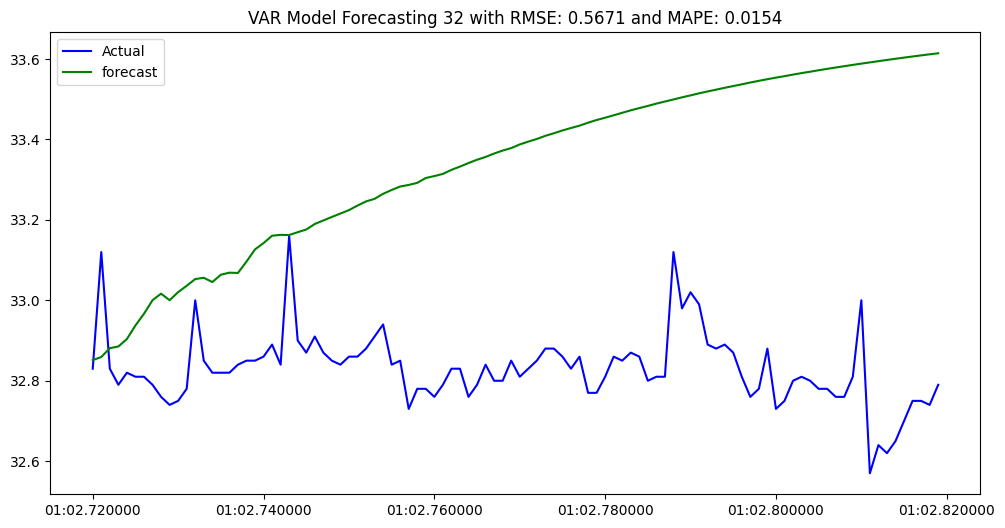

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.867489  503.324382
1970-01-01 00:01:02.721  32.872543  503.282217
1970-01-01 00:01:02.722  32.892400  503.202741
1970-01-01 00:01:02.723  32.899468  503.136230
1970-01-01 00:01:02.724  32.915184  502.967399
...                            ...         ...
1970-01-01 00:01:02.815  33.575897  501.594753
1970-01-01 00:01:02.816  33.578661  501.578679
1970-01-01 00:01:02.817  33.581390  501.562820
1970-01-01 00:01:02.818  33.584016  501.546775
1970-01-01 00:01:02.819  33.586519  501.530661

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


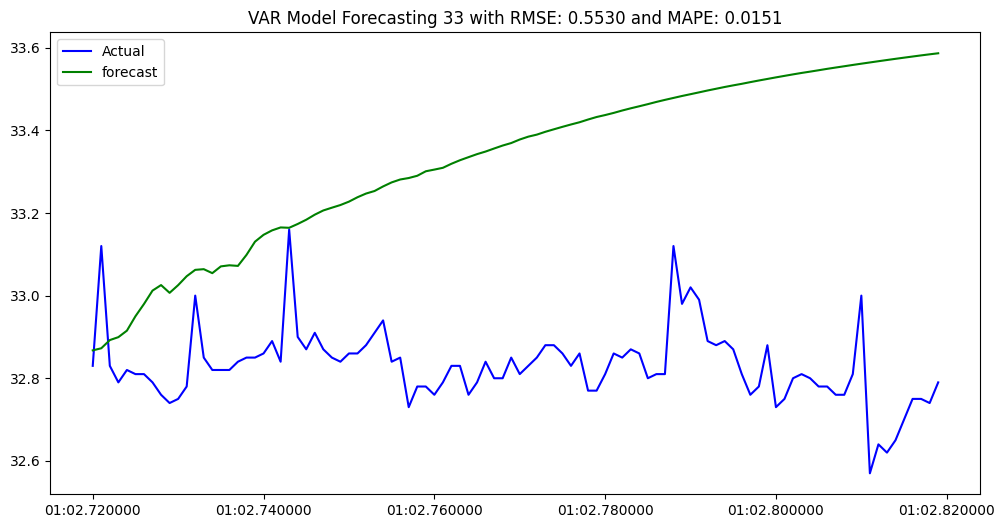

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.886461  503.394452
1970-01-01 00:01:02.721  32.872716  503.266652
1970-01-01 00:01:02.722  32.892007  503.191814
1970-01-01 00:01:02.723  32.902954  503.134376
1970-01-01 00:01:02.724  32.914125  502.967266
...                            ...         ...
1970-01-01 00:01:02.815  33.603372  502.110033
1970-01-01 00:01:02.816  33.606090  502.097000
1970-01-01 00:01:02.817  33.608786  502.084413
1970-01-01 00:01:02.818  33.611377  502.071492
1970-01-01 00:01:02.819  33.613874  502.058382

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


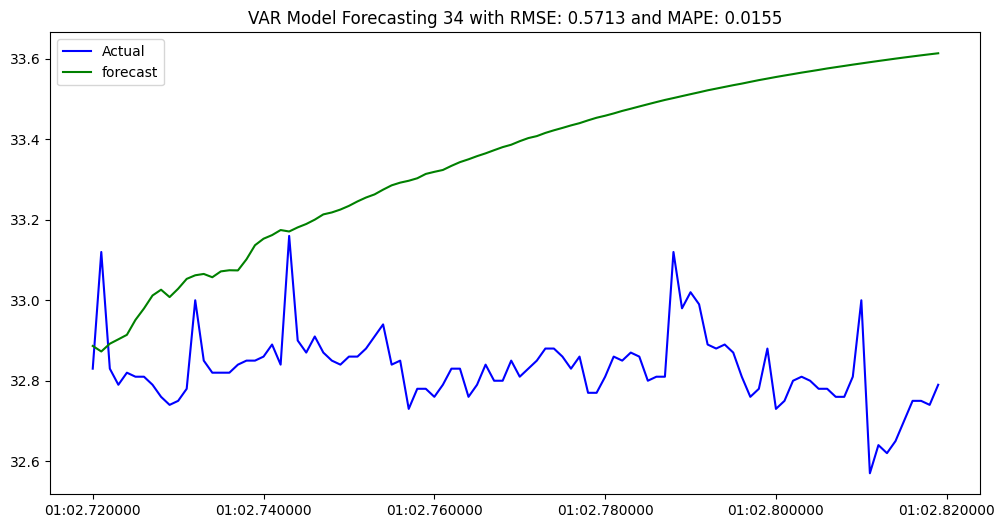

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.889086  503.400179
1970-01-01 00:01:02.721  32.886682  503.300792
1970-01-01 00:01:02.722  32.888946  503.175598
1970-01-01 00:01:02.723  32.900959  503.122262
1970-01-01 00:01:02.724  32.915188  502.960459
...                            ...         ...
1970-01-01 00:01:02.815  33.629363  502.511057
1970-01-01 00:01:02.816  33.632069  502.500525
1970-01-01 00:01:02.817  33.634673  502.490079
1970-01-01 00:01:02.818  33.637206  502.479432
1970-01-01 00:01:02.819  33.639661  502.468578

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


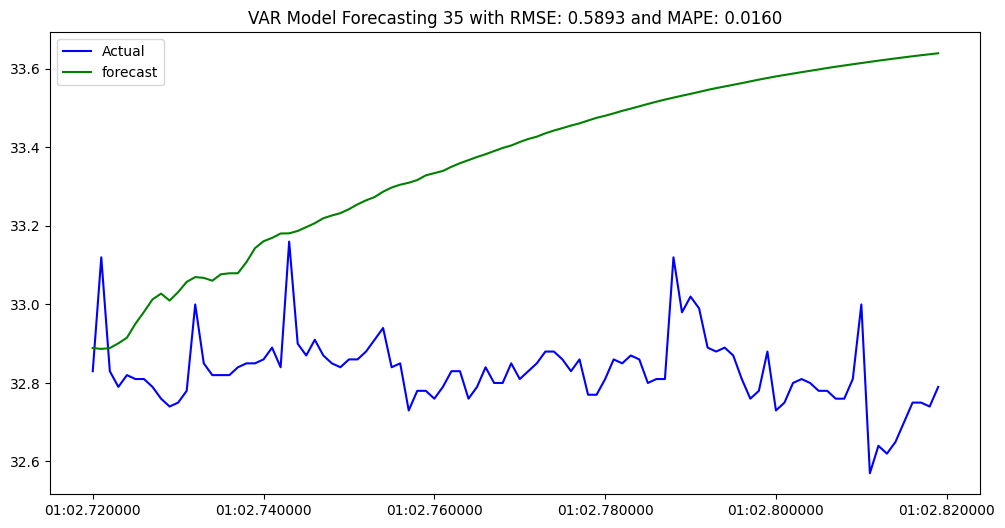

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.889127  503.409906
1970-01-01 00:01:02.721  32.886581  503.322283
1970-01-01 00:01:02.722  32.888616  503.253620
1970-01-01 00:01:02.723  32.899803  503.139520
1970-01-01 00:01:02.724  32.914750  502.978404
...                            ...         ...
1970-01-01 00:01:02.815  33.636466  502.754782
1970-01-01 00:01:02.816  33.639168  502.745623
1970-01-01 00:01:02.817  33.641750  502.736586
1970-01-01 00:01:02.818  33.644250  502.727209
1970-01-01 00:01:02.819  33.646665  502.717661

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


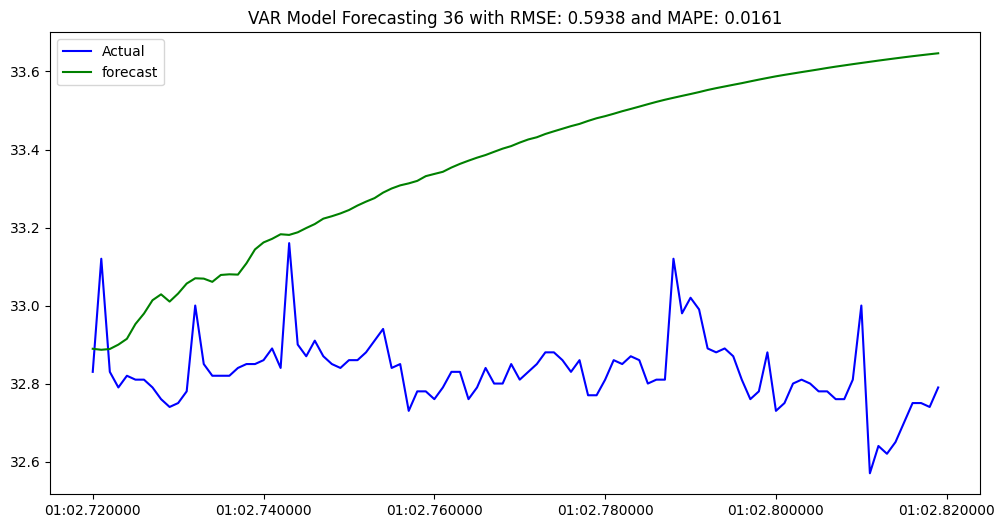

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.883882  503.393260
1970-01-01 00:01:02.721  32.879380  503.297849
1970-01-01 00:01:02.722  32.877963  503.215239
1970-01-01 00:01:02.723  32.869003  503.038549
1970-01-01 00:01:02.724  32.904553  502.920305
...                            ...         ...
1970-01-01 00:01:02.815  33.614121  502.435560
1970-01-01 00:01:02.816  33.616854  502.425388
1970-01-01 00:01:02.817  33.619460  502.414874
1970-01-01 00:01:02.818  33.622054  502.404115
1970-01-01 00:01:02.819  33.624562  502.393457

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


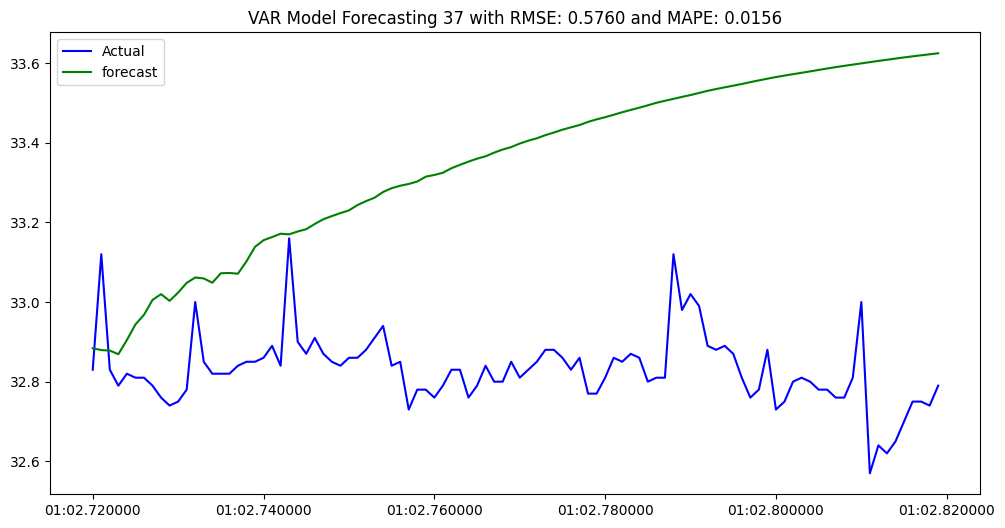

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.880603  503.390955
1970-01-01 00:01:02.721  32.871835  503.299575
1970-01-01 00:01:02.722  32.865679  503.210973
1970-01-01 00:01:02.723  32.851242  503.030598
1970-01-01 00:01:02.724  32.855557  502.906957
...                            ...         ...
1970-01-01 00:01:02.815  33.561495  502.000771
1970-01-01 00:01:02.816  33.564353  501.987917
1970-01-01 00:01:02.817  33.567103  501.975423
1970-01-01 00:01:02.818  33.569746  501.962382
1970-01-01 00:01:02.819  33.572329  501.949190

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


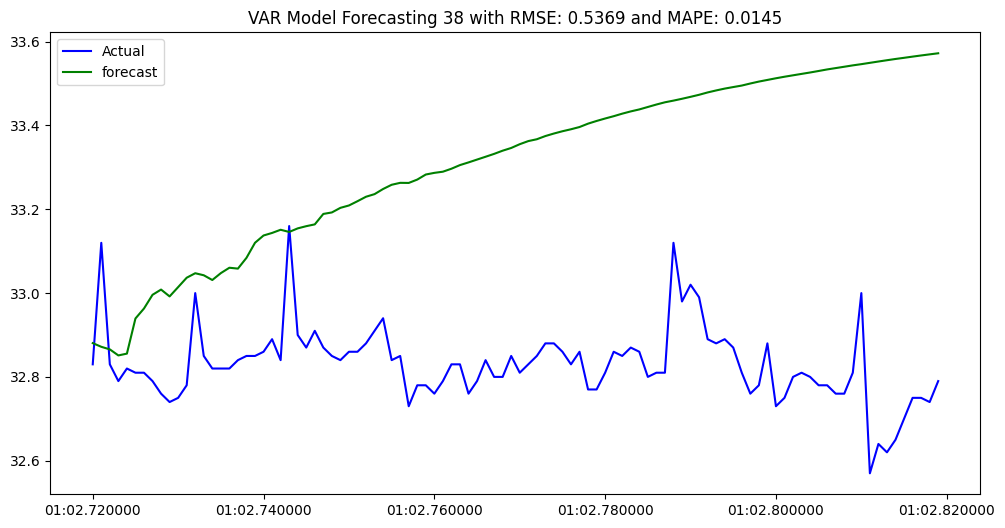

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.882973  503.393096
1970-01-01 00:01:02.721  32.874024  503.305943
1970-01-01 00:01:02.722  32.882208  503.222872
1970-01-01 00:01:02.723  32.869296  503.054647
1970-01-01 00:01:02.724  32.880783  502.943380
...                            ...         ...
1970-01-01 00:01:02.815  33.572003  502.291909
1970-01-01 00:01:02.816  33.574956  502.279986
1970-01-01 00:01:02.817  33.577715  502.268519
1970-01-01 00:01:02.818  33.580307  502.256184
1970-01-01 00:01:02.819  33.583073  502.244197

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


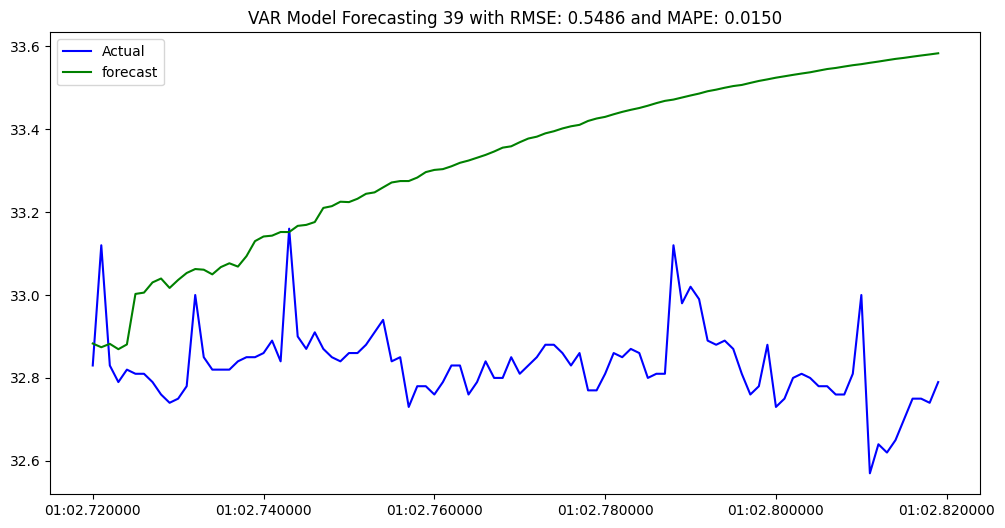

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.887018  503.376628
1970-01-01 00:01:02.721  32.876730  503.296453
1970-01-01 00:01:02.722  32.884956  503.211858
1970-01-01 00:01:02.723  32.866534  503.058452
1970-01-01 00:01:02.724  32.878779  502.940406
...                            ...         ...
1970-01-01 00:01:02.815  33.574217  502.117590
1970-01-01 00:01:02.816  33.577307  502.104940
1970-01-01 00:01:02.817  33.579869  502.092026
1970-01-01 00:01:02.818  33.582406  502.078294
1970-01-01 00:01:02.819  33.585291  502.065400

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


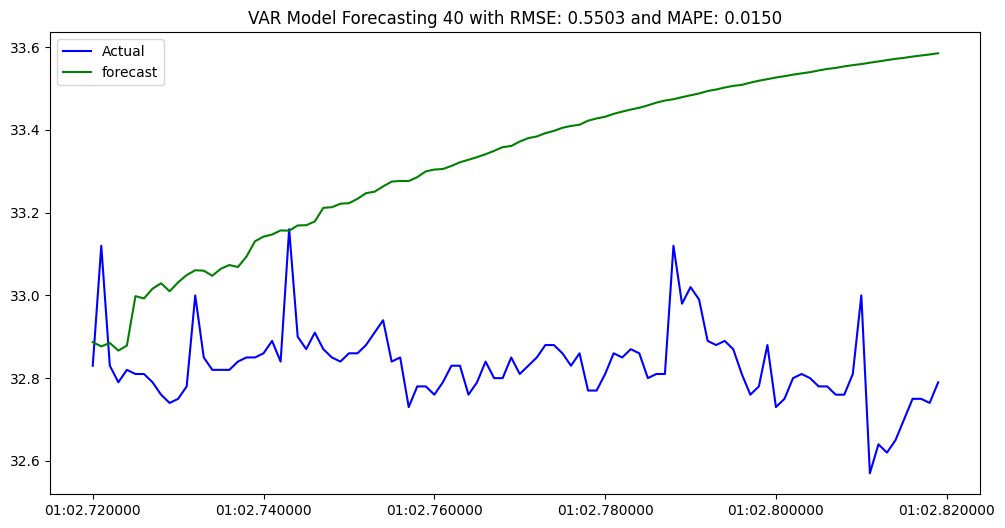

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.882228  503.348143
1970-01-01 00:01:02.721  32.867136  503.239880
1970-01-01 00:01:02.722  32.878115  503.168813
1970-01-01 00:01:02.723  32.858097  503.013355
1970-01-01 00:01:02.724  32.876289  502.938677
...                            ...         ...
1970-01-01 00:01:02.815  33.550460  501.945513
1970-01-01 00:01:02.816  33.553873  501.932798
1970-01-01 00:01:02.817  33.556537  501.918809
1970-01-01 00:01:02.818  33.558957  501.903833
1970-01-01 00:01:02.819  33.562035  501.889107

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


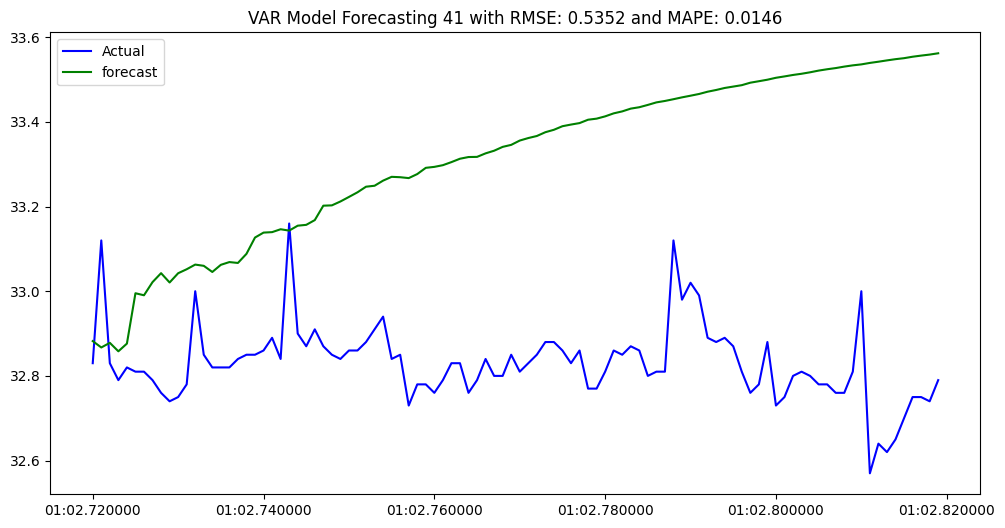

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.883051  503.344474
1970-01-01 00:01:02.721  32.868759  503.233046
1970-01-01 00:01:02.722  32.880242  503.164098
1970-01-01 00:01:02.723  32.859173  503.016410
1970-01-01 00:01:02.724  32.876685  502.949349
...                            ...         ...
1970-01-01 00:01:02.815  33.556459  502.472748
1970-01-01 00:01:02.816  33.559763  502.464194
1970-01-01 00:01:02.817  33.562469  502.453325
1970-01-01 00:01:02.818  33.564906  502.439642
1970-01-01 00:01:02.819  33.568124  502.427773

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.879546  503.341446
1970-01-01 00:01:02.721  32.864437  503.227272
1970-01-01 00:01:02.722  32.874930  503.155038
1970-01-01 00:01:02.723  32.852160  503.011351
1970-01-01 00:01:02.724  32.870695  502.951173
...                            ...         ...
1970-01-01 00:01:02.815  33.567445  503.195829
1970-01-01 00:01:02.816  33.570459  503.190204
1970-01-01 00:01:02.817  33.573129  503.184939
1970-01-01 00:01:02.818  33.575638  503.175656
1970-01-01 00:01:02.819  33.578795  503.165390

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


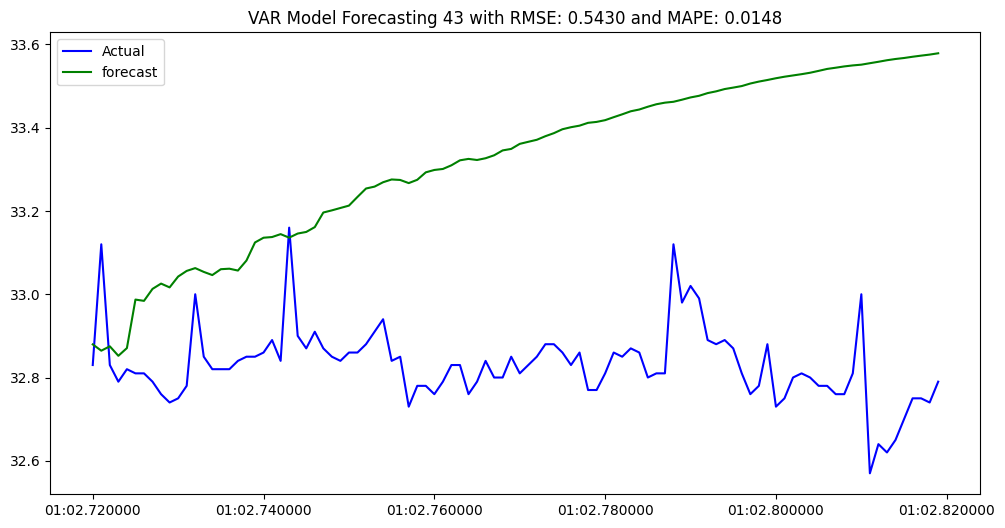

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.877302  503.339403
1970-01-01 00:01:02.721  32.860634  503.217987
1970-01-01 00:01:02.722  32.870953  503.142958
1970-01-01 00:01:02.723  32.847518  502.996236
1970-01-01 00:01:02.724  32.865579  502.932097
...                            ...         ...
1970-01-01 00:01:02.815  33.581465  503.260149
1970-01-01 00:01:02.816  33.584604  503.254298
1970-01-01 00:01:02.817  33.587186  503.249163
1970-01-01 00:01:02.818  33.589717  503.240032
1970-01-01 00:01:02.819  33.592783  503.230082

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.875092  503.351448
1970-01-01 00:01:02.721  32.855937  503.204669
1970-01-01 00:01:02.722  32.864075  503.131513
1970-01-01 00:01:02.723  32.840682  502.985213
1970-01-01 00:01:02.724  32.856575  502.917940
...                            ...         ...
1970-01-01 00:01:02.815  33.615304  504.176187
1970-01-01 00:01:02.816  33.618356  504.174432
1970-01-01 00:01:02.817  33.621535  504.174107
1970-01-01 00:01:02.818  33.623567  504.168868
1970-01-01 00:01:02.819  33.626693  504.164874

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.870755  503.331874
1970-01-01 00:01:02.721  32.845368  503.162651
1970-01-01 00:01:02.722  32.854150  503.074257
1970-01-01 00:01:02.723  32.824512  502.900447
1970-01-01 00:01:02.724  32.839128  502.823052
...                            ...         ...
1970-01-01 00:01:02.815  33.603309  504.222404
1970-01-01 00:01:02.816  33.606851  504.219602
1970-01-01 00:01:02.817  33.609615  504.215567
1970-01-01 00:01:02.818  33.611797  504.209676
1970-01-01 00:01:02.819  33.614634  504.205772

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.871841  503.337980
1970-01-01 00:01:02.721  32.847276  503.173707
1970-01-01 00:01:02.722  32.856576  503.088692
1970-01-01 00:01:02.723  32.828423  502.923925
1970-01-01 00:01:02.724  32.844101  502.853941
...                            ...         ...
1970-01-01 00:01:02.815  33.589347  503.964716
1970-01-01 00:01:02.816  33.592821  503.959798
1970-01-01 00:01:02.817  33.595381  503.955289
1970-01-01 00:01:02.818  33.597643  503.949160
1970-01-01 00:01:02.819  33.600346  503.945012

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


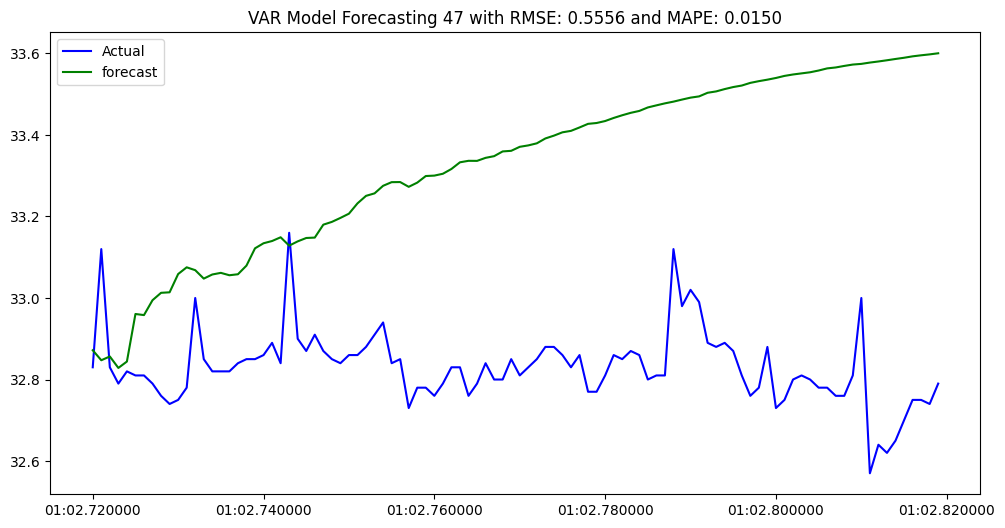

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.869725  503.335090
1970-01-01 00:01:02.721  32.850913  503.177096
1970-01-01 00:01:02.722  32.868514  503.107774
1970-01-01 00:01:02.723  32.851041  502.969588
1970-01-01 00:01:02.724  32.869150  502.907300
...                            ...         ...
1970-01-01 00:01:02.815  33.594297  504.177270
1970-01-01 00:01:02.816  33.599427  504.176102
1970-01-01 00:01:02.817  33.601525  504.171461
1970-01-01 00:01:02.818  33.603071  504.165207
1970-01-01 00:01:02.819  33.606672  504.163491

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


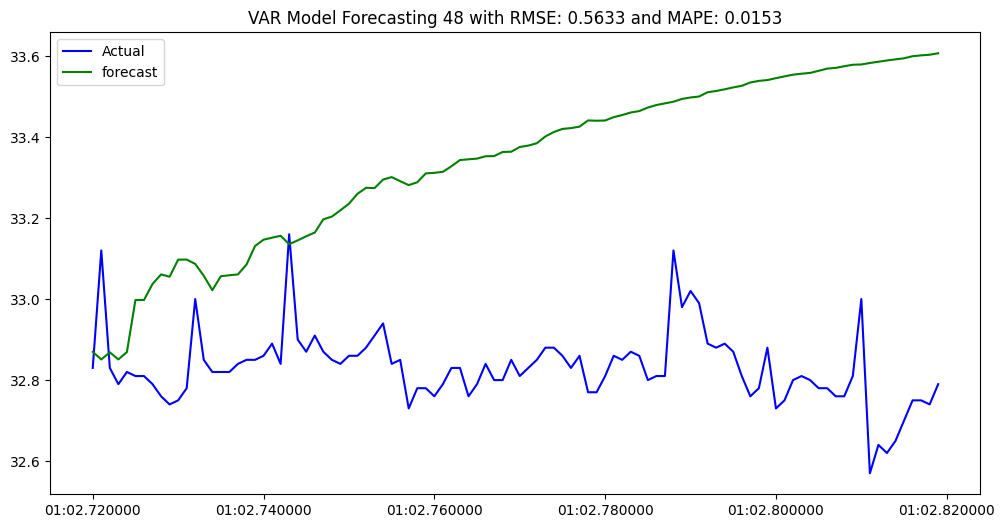

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.870506  503.286080
1970-01-01 00:01:02.721  32.851768  503.132785
1970-01-01 00:01:02.722  32.870283  503.084905
1970-01-01 00:01:02.723  32.850356  502.995873
1970-01-01 00:01:02.724  32.867176  503.023533
...                            ...         ...
1970-01-01 00:01:02.815  33.605754  505.448557
1970-01-01 00:01:02.816  33.609735  505.455129
1970-01-01 00:01:02.817  33.611592  505.460313
1970-01-01 00:01:02.818  33.613446  505.460969
1970-01-01 00:01:02.819  33.617787  505.458827

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.870637  503.287837
1970-01-01 00:01:02.721  32.853431  503.121243
1970-01-01 00:01:02.722  32.872058  503.075036
1970-01-01 00:01:02.723  32.851074  502.992635
1970-01-01 00:01:02.724  32.865474  503.032782
...                            ...         ...
1970-01-01 00:01:02.815  33.607754  505.771390
1970-01-01 00:01:02.816  33.611462  505.777299
1970-01-01 00:01:02.817  33.613145  505.783461
1970-01-01 00:01:02.818  33.614644  505.786224
1970-01-01 00:01:02.819  33.619147  505.785483

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.870997  503.290595
1970-01-01 00:01:02.721  32.854050  503.125526
1970-01-01 00:01:02.722  32.872895  503.084712
1970-01-01 00:01:02.723  32.852000  503.002846
1970-01-01 00:01:02.724  32.865765  503.037609
...                            ...         ...
1970-01-01 00:01:02.815  33.609718  505.758601
1970-01-01 00:01:02.816  33.613449  505.765083
1970-01-01 00:01:02.817  33.615456  505.771305
1970-01-01 00:01:02.818  33.616876  505.774134
1970-01-01 00:01:02.819  33.621338  505.772664

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


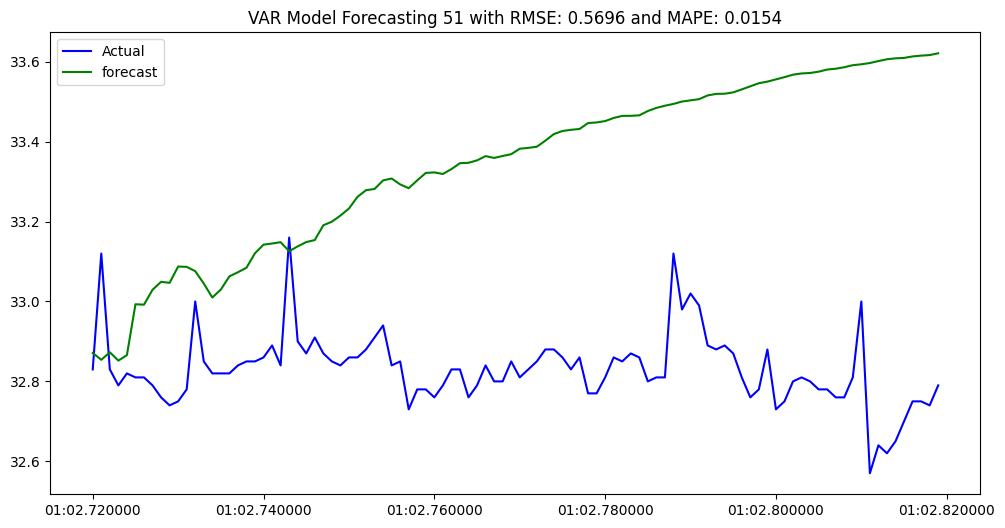

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.869394  503.301908
1970-01-01 00:01:02.721  32.852290  503.151189
1970-01-01 00:01:02.722  32.870493  503.118676
1970-01-01 00:01:02.723  32.851336  503.066995
1970-01-01 00:01:02.724  32.864908  503.105040
...                            ...         ...
1970-01-01 00:01:02.815  33.591937  505.591405
1970-01-01 00:01:02.816  33.595210  505.595049
1970-01-01 00:01:02.817  33.597934  505.600094
1970-01-01 00:01:02.818  33.601268  505.603201
1970-01-01 00:01:02.819  33.604802  505.601092

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


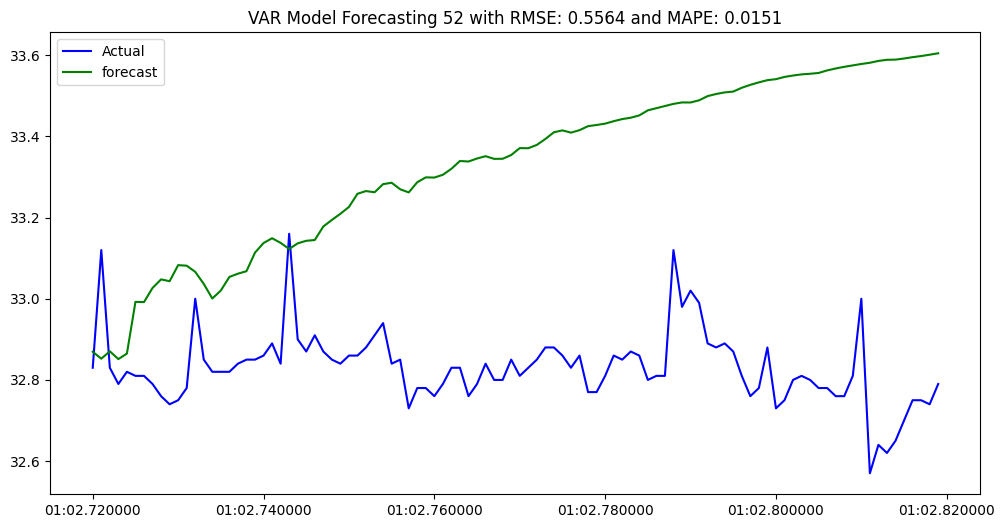

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.869238  503.304620
1970-01-01 00:01:02.721  32.851274  503.156306
1970-01-01 00:01:02.722  32.870478  503.125288
1970-01-01 00:01:02.723  32.851522  503.075783
1970-01-01 00:01:02.724  32.868603  503.117423
...                            ...         ...
1970-01-01 00:01:02.815  33.574262  505.526965
1970-01-01 00:01:02.816  33.578242  505.528950
1970-01-01 00:01:02.817  33.580806  505.533148
1970-01-01 00:01:02.818  33.584155  505.535969
1970-01-01 00:01:02.819  33.588361  505.532774

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.870053  503.358729
1970-01-01 00:01:02.721  32.853191  503.197694
1970-01-01 00:01:02.722  32.874724  503.157184
1970-01-01 00:01:02.723  32.857926  503.124514
1970-01-01 00:01:02.724  32.874000  503.171086
...                            ...         ...
1970-01-01 00:01:02.815  33.594981  505.282671
1970-01-01 00:01:02.816  33.597970  505.285578
1970-01-01 00:01:02.817  33.599676  505.293949
1970-01-01 00:01:02.818  33.601817  505.295174
1970-01-01 00:01:02.819  33.607348  505.288076

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


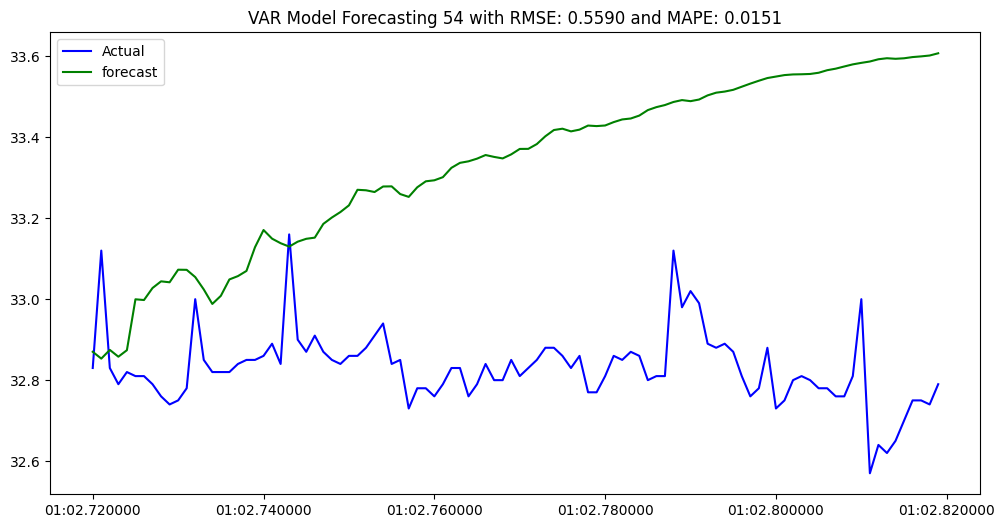

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.866407  503.410888
1970-01-01 00:01:02.721  32.844694  503.332479
1970-01-01 00:01:02.722  32.866206  503.274296
1970-01-01 00:01:02.723  32.851688  503.244404
1970-01-01 00:01:02.724  32.868708  503.318079
...                            ...         ...
1970-01-01 00:01:02.815  33.601914  505.425744
1970-01-01 00:01:02.816  33.604507  505.414417
1970-01-01 00:01:02.817  33.602453  505.417577
1970-01-01 00:01:02.818  33.605053  505.430658
1970-01-01 00:01:02.819  33.609475  505.419376

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.863986  503.730346
1970-01-01 00:01:02.721  32.853481  503.454752
1970-01-01 00:01:02.722  32.867622  503.304813
1970-01-01 00:01:02.723  32.861928  503.325896
1970-01-01 00:01:02.724  32.860149  503.419560
...                            ...         ...
1970-01-01 00:01:02.815  33.564575  505.816970
1970-01-01 00:01:02.816  33.569493  505.812063
1970-01-01 00:01:02.817  33.568097  505.829118
1970-01-01 00:01:02.818  33.575362  505.861179
1970-01-01 00:01:02.819  33.580168  505.827441

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


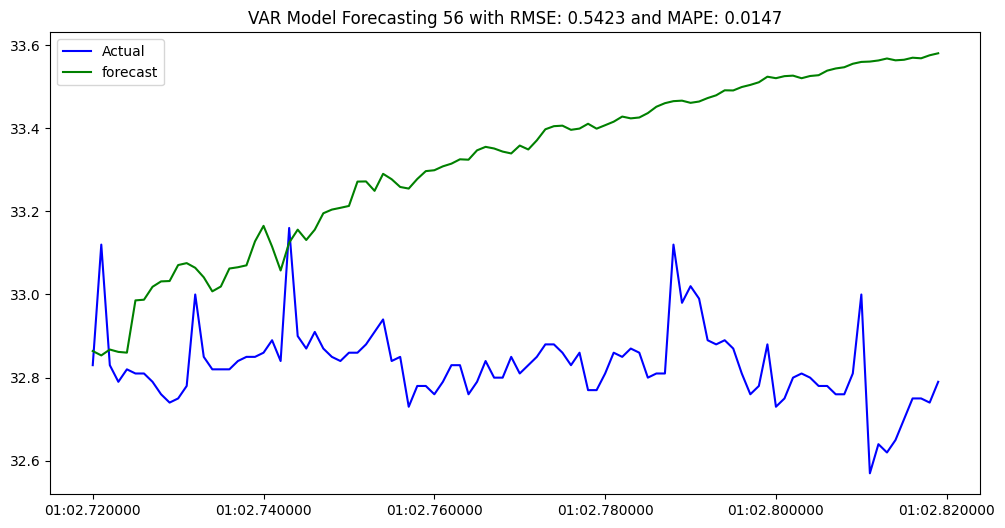

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.861501  503.737460
1970-01-01 00:01:02.721  32.831747  503.337230
1970-01-01 00:01:02.722  32.860118  503.313620
1970-01-01 00:01:02.723  32.859729  503.323290
1970-01-01 00:01:02.724  32.850994  503.387757
...                            ...         ...
1970-01-01 00:01:02.815  33.516569  504.654676
1970-01-01 00:01:02.816  33.523305  504.659322
1970-01-01 00:01:02.817  33.521357  504.664921
1970-01-01 00:01:02.818  33.526020  504.682947
1970-01-01 00:01:02.819  33.532100  504.639669

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.852614  503.699879
1970-01-01 00:01:02.721  32.818399  503.280899
1970-01-01 00:01:02.722  32.824320  503.137818
1970-01-01 00:01:02.723  32.832496  503.198649
1970-01-01 00:01:02.724  32.837635  503.301662
...                            ...         ...
1970-01-01 00:01:02.815  33.520956  504.459788
1970-01-01 00:01:02.816  33.528670  504.477280
1970-01-01 00:01:02.817  33.526101  504.474712
1970-01-01 00:01:02.818  33.529679  504.489672
1970-01-01 00:01:02.819  33.535126  504.444966

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


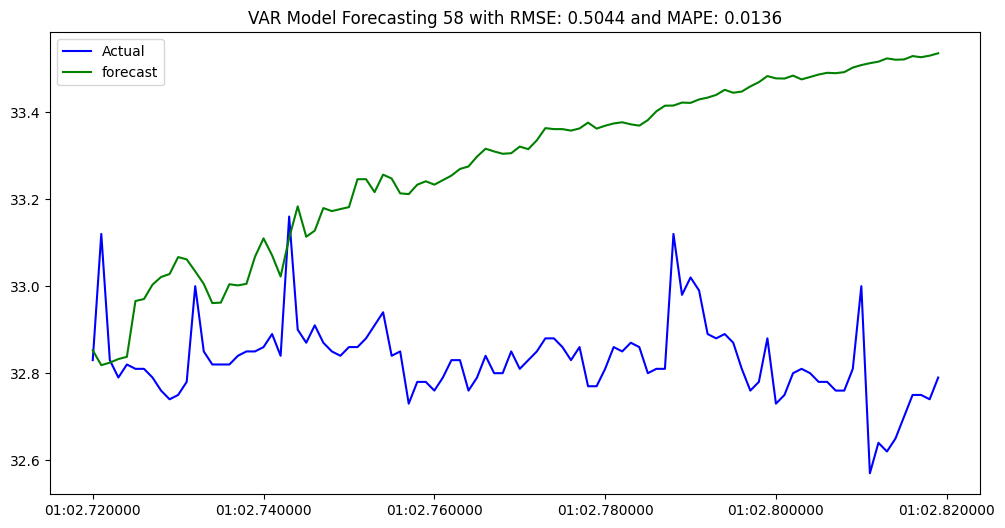

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.847072  503.719449
1970-01-01 00:01:02.721  32.826314  503.256001
1970-01-01 00:01:02.722  32.838181  503.098229
1970-01-01 00:01:02.723  32.885318  503.057587
1970-01-01 00:01:02.724  32.867247  503.231916
...                            ...         ...
1970-01-01 00:01:02.815  33.538130  504.493175
1970-01-01 00:01:02.816  33.545874  504.500536
1970-01-01 00:01:02.817  33.544399  504.507058
1970-01-01 00:01:02.818  33.546989  504.516216
1970-01-01 00:01:02.819  33.551542  504.469582

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


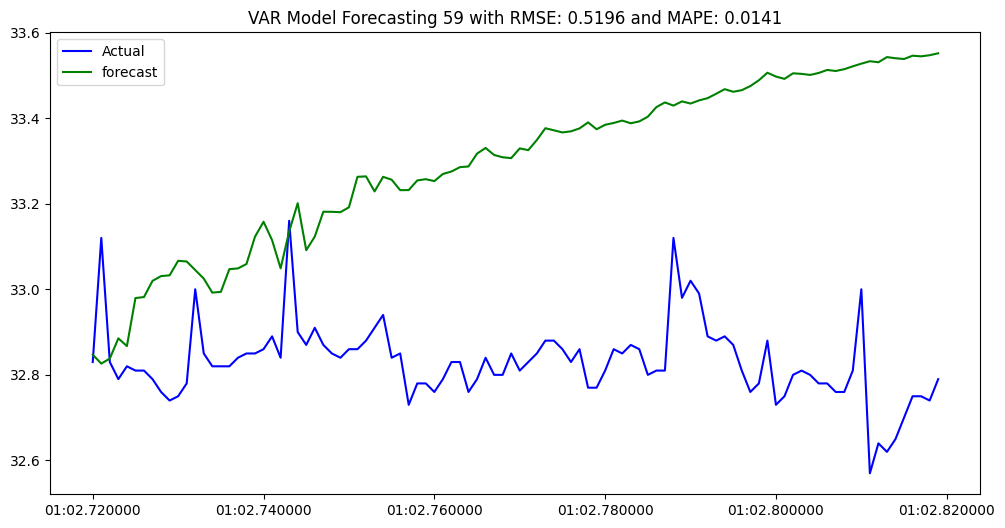

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.842875  503.721309
1970-01-01 00:01:02.721  32.823044  503.240762
1970-01-01 00:01:02.722  32.829333  503.109469
1970-01-01 00:01:02.723  32.875972  503.080373
1970-01-01 00:01:02.724  32.828878  503.312151
...                            ...         ...
1970-01-01 00:01:02.815  33.489952  504.152410
1970-01-01 00:01:02.816  33.498980  504.157668
1970-01-01 00:01:02.817  33.495811  504.168935
1970-01-01 00:01:02.818  33.497514  504.167634
1970-01-01 00:01:02.819  33.503924  504.123726

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


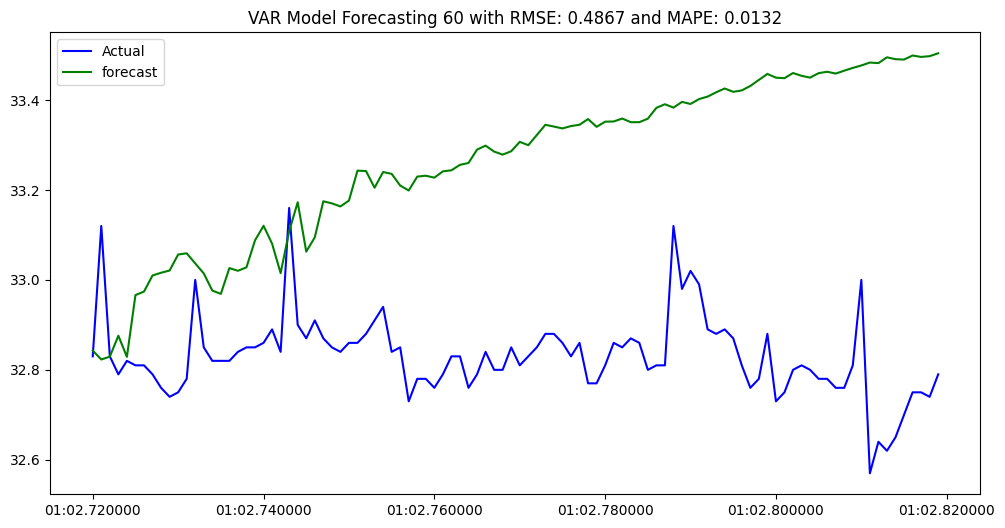

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.845753  503.692713
1970-01-01 00:01:02.721  32.829115  503.196491
1970-01-01 00:01:02.722  32.836475  503.073327
1970-01-01 00:01:02.723  32.883666  503.014452
1970-01-01 00:01:02.724  32.835031  503.245056
...                            ...         ...
1970-01-01 00:01:02.815  33.516540  503.595790
1970-01-01 00:01:02.816  33.522871  503.604069
1970-01-01 00:01:02.817  33.520837  503.611251
1970-01-01 00:01:02.818  33.525069  503.605836
1970-01-01 00:01:02.819  33.530922  503.559117

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency L will be used.
  self._init_dates(dates, freq)


                             sound         co2
1970-01-01 00:01:02.720  32.844772  503.684947
1970-01-01 00:01:02.721  32.830252  503.208535
1970-01-01 00:01:02.722  32.837891  503.094619
1970-01-01 00:01:02.723  32.883207  503.029064
1970-01-01 00:01:02.724  32.838133  503.281858
...                            ...         ...
1970-01-01 00:01:02.815  33.530786  504.040116
1970-01-01 00:01:02.816  33.536369  504.049084
1970-01-01 00:01:02.817  33.533807  504.053936
1970-01-01 00:01:02.818  33.536687  504.049512
1970-01-01 00:01:02.819  33.542723  504.004468

[100 rows x 2 columns]
                         sound    co2                   index
1970-01-01 00:01:02.720  32.83  503.5 1970-01-01 00:01:02.720
1970-01-01 00:01:02.721  33.12  504.8 1970-01-01 00:01:02.721
1970-01-01 00:01:02.722  32.83  504.4 1970-01-01 00:01:02.722
1970-01-01 00:01:02.723  32.79  504.2 1970-01-01 00:01:02.723
1970-01-01 00:01:02.724  32.82  504.3 1970-01-01 00:01:02.724
...                        ...    ...   

/var/folders/h1/51gwhnpd1clckvz788qgbbbm0000gn/T/ipykernel_9527/3163967311.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_counterpart["index"] = real_data_counterpart.index


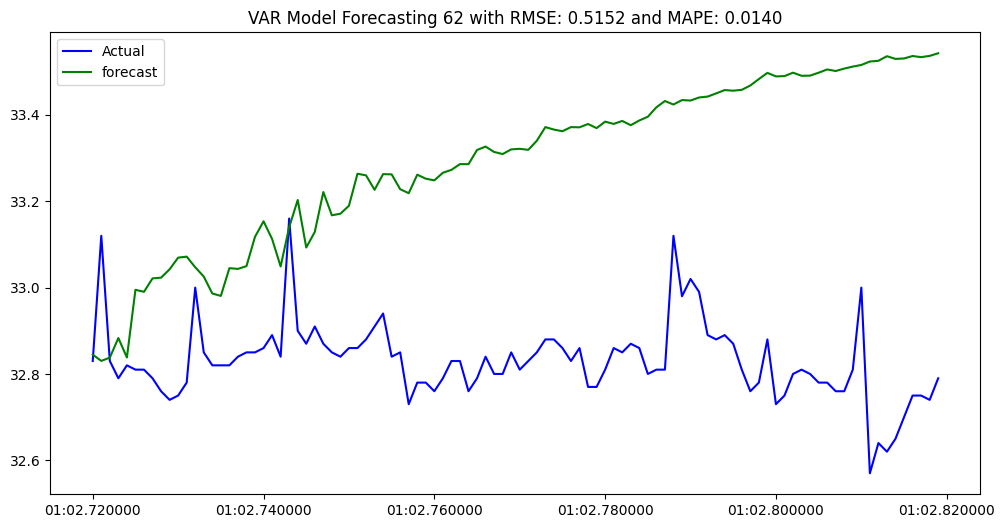

Best case: lag order 60 with MAPE 0.013167573208125258


In [284]:
# Split the data into training and testing sets
from sklearn.metrics import mean_absolute_percentage_error

train_size = int(0.8 * len(data))
print("Train size {0}".format(train_size))
train, test = data.iloc[:train_size], data.iloc[train_size:]
real_data_counterpart = test.head(steps)

max_lag_order = 62
results = {}
for l in range(1, max_lag_order+1):

    # Fit VAR model
    model = VAR(train)
    model_fitted = model.fit(l)

    # Forecasting
    lag_order = model_fitted.k_ar
    forecast = model_fitted.forecast(train.values[-lag_order:], steps=steps)

    # Invert the transformation
    forecast = pd.DataFrame(forecast, columns=data.columns)
    forecast = forecast.set_index(real_data_counterpart.index)
    # Calculate RMSE
    rmse_val = np.sqrt(mean_squared_error(forecast[key], real_data_counterpart[key]))
    mape_val = np.mean(mean_absolute_percentage_error(forecast[key], real_data_counterpart[key]))  # MAPE
    print(forecast)
    print(real_data_counterpart)
    d = data.copy()
    real_data_counterpart["index"] = real_data_counterpart.index
    forecast["index"] = forecast.index
    results[lag_order] = mape_val
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(real_data_counterpart['index'], real_data_counterpart[key], label='Actual', color='blue')
    plt.plot(forecast["index"], forecast[key], label='forecast', color='green')
    plt.title(f'VAR Model Forecasting {lag_order} with RMSE: {rmse_val:.4f} and MAPE: {mape_val:.4f}')
    plt.legend() 
    plt.show()

min_key = min(results, key=results.get)
print("Best case: lag order {0} with MAPE {1}".format(min_key, results[min_key]))